# Feature Visualization
In this Notebook I develop visualization techniques for the features used in the classification project.

In [1]:
import numpy as np
import pandas as pd
from pandas import DataFrame as DF
import matplotlib.pyplot as plt
from pandas.plotting import table
import seaborn as sns

pd.options.display.max_rows = 100
pd.options.display.max_columns = 200
%matplotlib inline


In [2]:
# converters
term_c = lambda x: 0 if x.lstrip() == '36 months' else 1 # np.int32(x.lstrip()[:2]) # keep the numerical part of term and convert to int
pct_c = lambda x: x if pd.isnull(x) else np.float32(x.strip('%')) # strip the percent sign from interest rate
grade_d = {'A': 7, 'B': 6, 'C': 5, 'D': 4, 'E': 3, 'F':2, 'G': 1}
grade_c = lambda x: grade_d.get(x)
loan_status_c = lambda x: 1 if ((x == 'Charged Off') | (x == 'Default')) else 0
emp_title_c = lambda x: 1 if x is np.nan else 0
log10_c = lambda x: np.log10(1 if x == 0 else x)
application_type_d = {'Individual': 1, 'Joint App': 0}
application_type_c = lambda x: application_type_d.get(x)
initial_list_status_c = lambda x: 0 if x == 'w' else 1

conv = {'term': term_c, 'int_rate':pct_c, 'grade': grade_c, 'loan_status': loan_status_c, 
        'emp_title': emp_title_c, 'annual_inc': log10_c, 'annual_inc_joint_c': log10_c,
       'application_type': application_type_c, 'revol_util': pct_c, 'revol_bal': log10_c,
       'initial_list_status': initial_list_status_c}


In [3]:
def get_missing(df, feature_list):
    '''
    Get a table of the featues and the number of missing values
    '''
    fm = [] 
    feat = []
    for feature in feature_list:
        sn = sum(df[feature].isnull())
        if sn > 0:
            fm.append(sn)
            feat.append(feature)
    return pd.DataFrame({'feature': feat, 'Missing': fm})

def chargeoff_rank(df, col):
    '''
    Calculate the rate of charge-off for a feature by category
    '''
    gls = df.groupby([col, 'loan_status']).size()
    glsx = gls.unstack('loan_status', fill_value=0)
    glsx['chargeoff_rate'] = round (glsx[1] / glsx[0] * 100, 2)
    glsx = glsx.reset_index()

    glsx.drop(columns=[0,1], inplace=True)
    glsx.sort_values(by='chargeoff_rate', inplace=True)#.unstack('zip_code')#.index #[['chargeoff_rate']]
    glsx.reset_index(drop=True, inplace=True)
    glsx.index.name = 'Index'
    glsx.columns = [col, 'chargeoff_rate']
    glsx = glsx.set_index(col)
    return glsx

def corr_heatmap(df, col):
    '''
    Print correlation coefficient and heat map
    '''
    cr = chargeoff_rank(df, col)
    crr = cr.reset_index()
    print("Correlation of {} and charge-off: {}".format(col, round(np.corrcoef(crr[col], crr.chargeoff_rate)[0,1], 3)))
    plt.figure(figsize=(20,1)); sns.heatmap(cr.T);

def analyze_col(df, col, showtable=True, showgroups=False, piesize=(6, 6)):
    '''
    Display a table, a pie chart showing relative percentages, and piecharts as good-to-chargeoff ratios.
    '''
    misv = df[col].isnull().sum()
    print("Missing values:", misv, " Missing percent:", misv / len(df))
    vc = DF(df[col].value_counts()).sort_values(by=col)
    if showtable:
        display(vc);
    n = len(vc.index) 
    plt.figure(figsize=piesize); plt.pie( vc, #df[col].value_counts(), 
                                    labels=vc.index.values, autopct="%.2f %%"); 
    plt.suptitle('Percentage of ' + col, fontsize=16);

    if not showgroups:
        return
    
    # pie chart for each group 
    gls = df.groupby([col, 'loan_status']).size()
    glsx = gls.unstack('loan_status')
    glsx['ratio'] = glsx[1] / glsx[0]
    sorted_ind = glsx.sort_values(by='ratio').index.values

    max_col = min(n, 4)
    n_rows = ((n - 1) // max_col)+1

    f, axs = plt.subplots(n_rows, max_col, figsize=(max_col * 6, n_rows * 6))
    for i, v in enumerate(sorted_ind): # vc.index.values):
        i += 1
        rows = ((i - 1) // max_col)+1
        cols = (i - 1) % max_col + 1
        
        plt.subplot(n_rows, max_col, i); 
        gls1 = gls.xs(v, level=0); gls1.index = ['Good' if v1 == 0 else 'Charge-off' for v1 in gls1.index.values]
        gls1.plot.pie(labels=gls1.index, autopct='%.2f',colors=['g', 'r'], title='Charge-off rate for ' + col + ' "' + str(v) + '"'); plt.ylabel('');
        if i == 1:
            plt.legend(labels= gls1.index, loc=1);
            
    # hide extra subplot axes
    for ax in axs.ravel():
        ax.axis('off')            

def percent_col(df, col, figsize=(8, 6)):
    '''
    Create a stacked percentage bar chart, indicating good to charge-off loan ratio.
    '''
    if df is None:
        # Data
        raw_data = {'Good': [20, 1.5, 7, 10, 5], 'Charge-off': [5, 15, 5, 10, 15]}
        df = pd.DataFrame(raw_data)
        col = 'color'
    else:
        df = df[['loan_status', col]].groupby(by=['loan_status', col]).size().unstack('loan_status')
        df.fillna(0, inplace=True)
        df.columns = ['Good', 'Charge-off']
        
    df['ratio'] = df['Charge-off'] / df['Good'] 
    df = df.sort_values(by='ratio')
    r = df.index.values

    # From raw value to percentage
    totals = [i+j for i, j in zip(df['Good'], df['Charge-off'])]
    greenBars  = [i / j * 100 for i, j in zip(df['Good'], totals)]
    orangeBars = [i / j * 100 for i, j in zip(df['Charge-off'], totals)]

    # plot
    f, ax = plt.subplots(figsize=figsize)
    barWidth = 0.85
    #names = ('A','B','C','D','E')
    # Create green Bars
    rects1 = plt.bar(r, greenBars, color='g', edgecolor='white', width=barWidth)
    # Create orange Bars
    rects2 = plt.bar(r, orangeBars, bottom=greenBars, color='r', edgecolor='white', width=barWidth)
    
    # Custom x axis
    #
    plt.xlabel(col)
    plt.xticks(r, rotation='vertical')

    plt.suptitle('Percent Charge-off vs ' + col)
    plt.legend(labels=['Good', 'Charge-off'], loc=2, bbox_to_anchor=(1, 1))
    
    
    def autolabel(rects):
        #Attach a text label above each bar displaying its height
        for rect in rects:
            height = rect.get_height()
            ax.text(rect.get_x() + rect.get_width()/2., rect.get_y() + 0.45*height,
                    '%.2f' % height,
                    ha='center', va='bottom')

    autolabel(rects1)
    autolabel(rects2)

    # Show graphic
    plt.show()

def plot_box_hist(df, col, title='', **kwargs):
    '''
    Show a box plot and a histogram of the column values.
    '''
    print("Missing values for", col, df[col].isnull().sum())
    f, (ax1, ax2) = plt.subplots(2,1, figsize=(20, 6));
    df[[col]].plot.box(vert=False, ax=ax1, title='Box plot of ' + title + ' (' + col + ')');
    #sns.distplot(df.dti_joint, bins=500, ax=ax2); ax2.set_title('Histogram of Debt to Income ratio for Joint App');
    df[[col]].plot.hist(ax=ax2, title='Histogram of ' + title + ' (' + col + ')', **kwargs);
    plt.show()

def plot_box_hist2(df, col, title='', **kwargs):
    '''
    Show a box plot and a histogram of the column values.
    '''
    print("Missing values for", col, df[col].isnull().sum())
    f, (ax1, ax2, ax3) = plt.subplots(3,1, figsize=(20, 9), sharex=True);
    df.boxplot(ax=ax1, column=col, by='loan_status', vert=False);
    df[df['loan_status'] == 1][col].plot.hist(ax=ax2, color='r', title='Charge-off ' + title + ' (' + col + ')', **kwargs);
    df[df['loan_status'] == 0][col].plot.hist(ax=ax3, color='g', title='Good loan ' + title + ' (' + col + ')', **kwargs);
    
    plt.show()
    
    
### Encoding functions
def dummies(df, col, prefix):
    '''
    One-hot encode the indicated column. You still need to assign df to the returned object.
    '''
    df = df.join(pd.get_dummies(df[[col]], prefix=prefix))
    df.drop(columns=col, inplace=True)
    return df

In [4]:
# import these columns. Data files from different quarters may have different columns.
usecols = ['loan_status', 'loan_amnt', 'term', 'int_rate', 'installment', 'grade', 'sub_grade', 'emp_length', 
           'home_ownership', 'annual_inc', 'verification_status', 'issue_d', 'pymnt_plan', 'purpose', 
           'zip_code', 'dti', 'delinq_2yrs', 'earliest_cr_line', 'fico_range_low', 'fico_range_high', 
           'inq_last_6mths', 'mths_since_last_delinq', 'mths_since_last_record', 'open_acc', 'pub_rec', 'emp_title',
           
           'revol_bal', 'revol_util', 'total_acc', 'initial_list_status', 
           'last_fico_range_high', 'last_fico_range_low', 'collections_12_mths_ex_med', 
           'mths_since_last_major_derog', 
           'application_type', 'annual_inc_joint', 'dti_joint', 
           'verification_status_joint', 
           
           'acc_now_delinq', 
           'tot_coll_amt', 
           'tot_cur_bal', 
           'open_acc_6m', 
           'open_act_il', 
           'open_il_12m', 'open_il_24m', 
           'mths_since_rcnt_il', 'total_bal_il', 'il_util',
           'open_rv_12m', 'open_rv_24m', 'max_bal_bc', 'all_util', 'total_rev_hi_lim', 
           'inq_fi', 'total_cu_tl', 'inq_last_12m', 'acc_open_past_24mths', 'avg_cur_bal', 
           'bc_open_to_buy', 'bc_util', 'chargeoff_within_12_mths', 'delinq_amnt', 
           'mo_sin_old_il_acct', 'mo_sin_old_rev_tl_op', 
           'mo_sin_rcnt_rev_tl_op', 'mo_sin_rcnt_tl', 'mort_acc', 'mths_since_recent_bc', 
           'mths_since_recent_bc_dlq', 'mths_since_recent_inq', 'mths_since_recent_revol_delinq', 
           'num_accts_ever_120_pd', 'num_actv_bc_tl', 'num_actv_rev_tl', 'num_bc_sats', 'num_bc_tl', 
           'num_il_tl', 'num_op_rev_tl', 'num_rev_accts', 'num_rev_tl_bal_gt_0', 'num_sats', 
           'num_tl_30dpd', 'num_tl_90g_dpd_24m', 'num_tl_op_past_12m', 'pct_tl_nvr_dlq', 'percent_bc_gt_75', 
           'pub_rec_bankruptcies', 'tax_liens', 'tot_hi_cred_lim', 'total_bal_ex_mort', 'total_bc_limit', 
           'total_il_high_credit_limit', 
           
           'revol_bal_joint', 'sec_app_fico_range_low', 'sec_app_fico_range_high', 
           'sec_app_earliest_cr_line', 'sec_app_inq_last_6mths', 'sec_app_mort_acc', 'sec_app_open_acc', 
           'sec_app_revol_util', 'sec_app_open_act_il', 'sec_app_num_rev_accts', 
           'sec_app_chargeoff_within_12_mths', 'sec_app_collections_12_mths_ex_med', 'sec_app_mths_since_last_major_derog']
          
dtype   = {'loan_amnt': np.float32, 'funded_amnt': np.float32, 'installment':np.float32}

conv = {}

X = pd.read_csv('data/LoanStats_securev1_2017Q1.csv', skiprows=1, skipfooter=2, engine='python', dtype=dtype, 
                 usecols=usecols, converters=conv)
df = X.copy()
display(df.head(5))
#df.dtypes

,loan_amnt,term,int_rate,installment,grade,sub_grade,emp_title,emp_length,home_ownership,annual_inc,verification_status,issue_d,loan_status,pymnt_plan,purpose,zip_code,dti,delinq_2yrs,earliest_cr_line,fico_range_low,fico_range_high,inq_last_6mths,mths_since_last_delinq,mths_since_last_record,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,last_fico_range_high,last_fico_range_low,collections_12_mths_ex_med,mths_since_last_major_derog,application_type,annual_inc_joint,dti_joint,verification_status_joint,acc_now_delinq,tot_coll_amt,tot_cur_bal,open_acc_6m,open_act_il,open_il_12m,open_il_24m,mths_since_rcnt_il,total_bal_il,il_util,open_rv_12m,open_rv_24m,max_bal_bc,all_util,total_rev_hi_lim,inq_fi,total_cu_tl,inq_last_12m,acc_open_past_24mths,avg_cur_bal,bc_open_to_buy,bc_util,chargeoff_within_12_mths,delinq_amnt,mo_sin_old_il_acct,mo_sin_old_rev_tl_op,mo_sin_rcnt_rev_tl_op,mo_sin_rcnt_tl,mort_acc,mths_since_recent_bc,mths_since_recent_bc_dlq,mths_since_recent_inq,mths_since_recent_revol_delinq,num_accts_ever_120_pd,num_actv_bc_tl,num_actv_rev_tl,num_bc_sats,num_bc_tl,num_il_tl,num_op_rev_tl,num_rev_accts,num_rev_tl_bal_gt_0,num_sats,num_tl_30dpd,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,revol_bal_joint,sec_app_fico_range_low,sec_app_fico_range_high,sec_app_earliest_cr_line,sec_app_inq_last_6mths,sec_app_mort_acc,sec_app_open_acc,sec_app_revol_util,sec_app_open_act_il,sec_app_num_rev_accts,sec_app_chargeoff_within_12_mths,sec_app_collections_12_mths_ex_med,sec_app_mths_since_last_major_derog
0,15000.0,36 months,5.32%,451.730011,A,A1,Executive Account Manager,10+ years,MORTGAGE,182000.0,Not Verified,Mar-2017,Current,n,debt_consolidation,751xx,9.35,0,Nov-1974,740,744,0,NaN,NaN,13,0,34623,33.7%,32,w,724,720,0,NaN,Individual,NaN,NaN,NaN,0,0,233521,0,1,0,1,24.0,2667,59.0,2,2,12503,42.0,102600,1,6,0,4,17963,55203.0,26.0,0,0,92.0,508,8,8,5,8.0,NaN,17.0,NaN,0,3,6,7,11,9,10,16,6,13,0,0,2,100.0,0.0,0,0,325464,50766,74600,4508,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,17000.0,36 months,7.49%,528.729980,A,A4,Air Traffic Controller,10+ years,MORTGAGE,120000.0,Not Verified,Mar-2017,Fully Paid,n,debt_consolidation,840xx,8.41,0,Oct-2005,735,739,0,72.0,89.0,9,1,15406,31.6%,34,w,754,750,0,75.0,Individual,NaN,NaN,NaN,0,0,290743,0,2,1,1,9.0,33276,86.0,0,2,5681,56.0,48800,1,0,1,3,32305,32394.0,32.2,0,0,137.0,119,24,9,2,24.0,NaN,9.0,NaN,0,4,4,5,6,24,6,8,4,9,0,0,1,94.1,20.0,1,0,374071,48682,47800,38667,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,20000.0,36 months,5.32%,602.299988,A,A1,Associate Dentist,3 years,RENT,120000.0,Not Verified,Mar-2017,Current,n,credit_card,926xx,26.54,0,Aug-2002,770,774,1,NaN,NaN,18,0,2646,3%,60,w,814,810,0,NaN,Individual,NaN,NaN,NaN,0,0,675385,1,10,1,2,3.0,672739,106.0,1,3,2075,51.0,87400,0,0,2,5,37521,84754.0,3.0,0,0,175.0,175,9,3,0,9.0,NaN,3.0,NaN,0,3,3,8,12,46,8,14,3,18,0,0,2,100.0,0.0,0,0,688272,675385,87400,600872,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,16000.0,60 months,12.74%,361.929993,C,C1,claims analyst,10+ years,MORTGAGE,130000.0,Not Verified,Mar-2017,Current,n,debt_consolidation,577xx,8.28,0,Jul-1995,680,684,0,42.0,79.0,16,1,8595,25.8%,48,w,754,750,0,NaN,Individual,NaN,NaN,NaN,0,0,44263,0,3,1,2,8.0,35668,77.0,2,6,4566,56.0,33300,3,9,6,8,2766,3350.0,58.1,0,0,141.0,260,10,8,3,23.0,NaN,8.0,42.0,0,2,5,2,12,12,13,33,5,16,0,0,3,97.6,50.0,1,0,79751,44263,8000,46451,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2000.0,36 months,16.99%,71.300003,D,D1,Supervisor,6 years,MORTGAGE,62000.0,Not Verified,Mar-2017,Current,n,credit_card,983xx,16.43,0,Oct-2007,680,684,2,57.0,44.0,10,2,6504,44.9%,20,f,659,655,0,57.0,Individual,NaN,NaN,NaN,0,0,321694,4,2,1,3,2.0,33320,87.0,5,7,3381,75.0,14500,3,4,4,11,32169,5591.0,51.4,0,0,113.0,113,6,2,2,6.0,NaN,0.0,NaN,1,3,5,5,7,8,7,10,5,10,0,0,7,100.0,40.0,2,0,337688,39824,11500,38491,NaN,NaN,NaN,NaN,

### Sample Data table
Generate images of tables usable in report

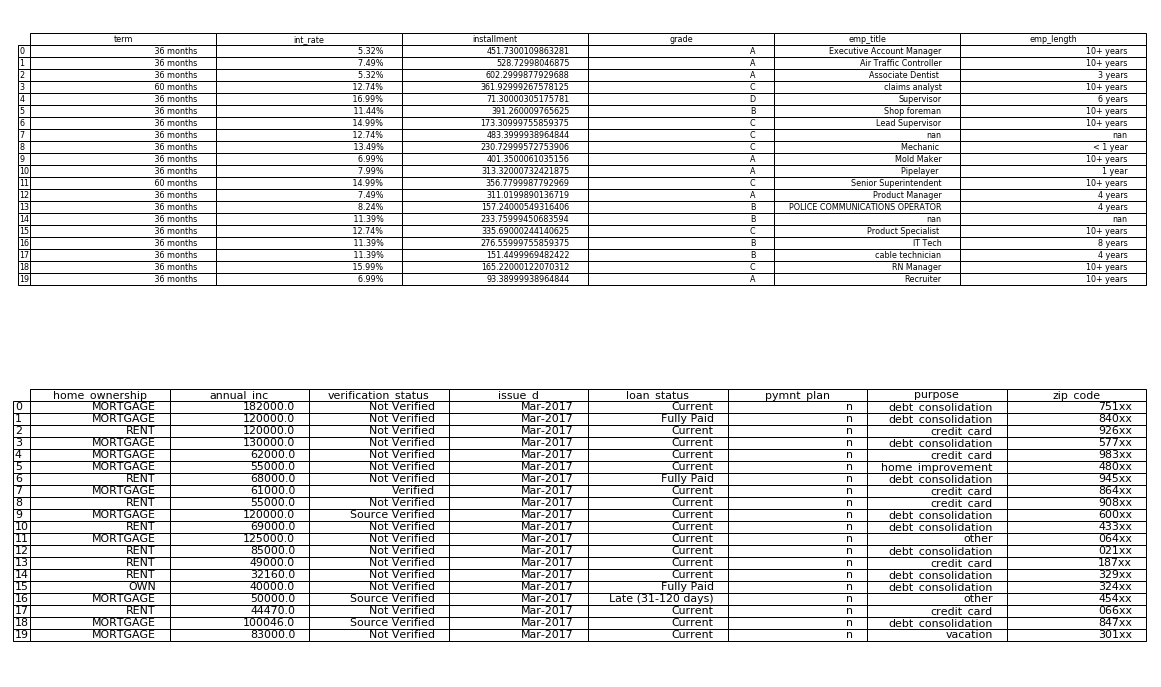

In [35]:
f, (ax1, ax2) = plt.subplots(2,1,figsize=(20,12));
tbl1 = table(ax1, df.head(20)[df.columns.values[[1,2,3,4,6,7]]], loc='center'); tbl1.set_fontsize(16);
tbl = table(ax2, df.head(20)[df.columns.values[8:16]], loc='center'); tbl.set_fontsize(16);

ax1.axis("off"); ax2.axis("off"); 


## Features

- [loan_amnt](#loan_amnt)
- [funded_amnt](#funded_amnt)  
- [term](#term)
- [int_rate](#int_rate)
- [installment](#installment)
- [grade](#grade)
- [sub_grade](#sub_grade)
- [emp_title](#emp_title)
- [emp_length](#emp_length)
- [home_ownership](#home_ownership)
- [annual_inc](#annual_inc)
- [verification_status](#verification_status)
- [pymnt_plan](#pymnt_plan)
- [purpose](#purpose)
- [zip_code](#zip_code)
- [dti](#dti)
- [dti_joint](#dti_joint)
- [delinq_2yrs](#delinq_2yrs)
- [earliest_cr_line](#earliest_cr_line)
- [fico_range_low](#fico_range_low)
- [fico_range_high](#fico_range_high)
- [fico_range_mean](#fico_range_mean)
- [inq_last_6mths](#inq_last_6mths)
- [mths_since_last_delinq](#mths_since_last_delinq)
- [mths_since_last_record](#mths_since_last_record)
- [open_acc](#open_acc)
- [pub_rec](#pub_rec)
- [revol_bal](#revol_bal)
- [revol_util](#revol_util)
- [total_acc](#total_acc)
- [initial_list_status](#initial_list_status)
- [last_credit_pull_d](#last_credit_pull_d)
- [last_fico_range_high](#last_fico_range_high)
- [last_fico_range_low](#last_fico_range_low)
- [collections_12_mths_ex_med](#collections_12_mths_ex_med)
- [mths_since_last_major_derog](#mths_since_last_major_derog)
- [application_type](#application_type)
- [annual_inc_joint](#annual_inc_joint)
- [verification_status_joint](#verification_status_joint)
- [acc_now_delinq](#acc_now_delinq)
- [tot_coll_amt](#tot_coll_amt)
- [tot_cur_bal](#tot_cur_bal)
- [open_acc_6m](#open_acc_6m)
- [open_act_il](#open_act_il)
- [open_il_12m](#open_il_12m)
- [open_il_24m](#open_il_24m)
- [mths_since_rcnt_il](#mths_since_rcnt_il)
- [total_bal_il](#total_bal_il)
- [il_util](#il_util)
- [open_rv_12m](#open_rv_12m)
- [open_rv_24m](#open_rv_24m)
- [max_bal_bc](#max_bal_bc)
- [all_util](#all_util)
- [total_rev_hi_lim](#total_rev_hi_lim)
- [inq_fi](#inq_fi)
- [total_cu_tl](#total_cu_tl)
- [inq_last_12m](#inq_last_12m)
- [acc_open_past_24mths](#acc_open_past_24mths)
- [avg_cur_bal](#avg_cur_bal)
- [bc_open_to_buy](#bc_open_to_buy)
- [bc_util](#bc_util)
- [chargeoff_within_12_mths](#chargeoff_within_12_mths)
- [delinq_amnt](#delinq_amnt)
- [mo_sin_old_il_acct](#mo_sin_old_il_acct)
- [mo_sin_old_rev_tl_op](#mo_sin_old_rev_tl_op)
- [mo_sin_rcnt_rev_tl_op](#mo_sin_rcnt_rev_tl_op)
- [mo_sin_rcnt_tl](#mo_sin_rcnt_tl)
- [mort_acc](#mort_acc)
- [mths_since_recent_bc](#mths_since_recent_bc)
- [mths_since_recent_bc_dlq](#mths_since_recent_bc_dlq)
- [mths_since_recent_inq](#mths_since_recent_inq)
- [mths_since_recent_revol_delinq](#mths_since_recent_revol_delinq)
- [num_accts_ever_120_pd](#num_accts_ever_120_pd)
- [num_actv_bc_tl](#num_actv_bc_tl)
- [num_actv_rev_tl](#num_actv_rev_tl)
- [num_bc_sats](#num_bc_sats)
- [num_bc_tl](#num_bc_tl)
- [num_il_tl](#num_il_tl)
- [num_op_rev_tl](#num_op_rev_tl)
- [num_rev_accts](#num_rev_accts)
- [num_rev_tl_bal_gt_0](#num_rev_tl_bal_gt_0)
- [num_sats](#num_sats)
- [num_tl_120dpd_2m](#num_tl_120dpd_2m)
- [num_tl_30dpd](#num_tl_30dpd)
- [num_tl_90g_dpd_24m](#num_tl_90g_dpd_24m)
- [num_tl_op_past_12m](#num_tl_op_past_12m)
- [pct_tl_nvr_dlq](#pct_tl_nvr_dlq)
- [percent_bc_gt_75](#percent_bc_gt_75)
- [pub_rec_bankruptcies](#pub_rec_bankruptcies)
- [tax_liens](#tax_liens)
- [tot_hi_cred_lim](#tot_hi_cred_lim)
- [total_bal_ex_mort](#total_bal_ex_mort)
- [total_bc_limit](#total_bc_limit)
- [total_il_high_credit_limit](#total_il_high_credit_limit)
- [revol_bal_joint](#revol_bal_joint)
- [sec_app_fico_range_low](#sec_app_fico_range_low)
- [sec_app_fico_range_high](#sec_app_fico_range_high)
- [sec_app_earliest_cr_line](#sec_app_earliest_cr_line)
- [sec_app_inq_last_6mths](#sec_app_inq_last_6mths)
- [sec_app_mort_acc](#sec_app_mort_acc)
- [sec_app_open_acc](#sec_app_open_acc)
- [sec_app_revol_util](#sec_app_revol_util)
- [sec_app_open_act_il](#sec_app_open_act_il)
- [sec_app_num_rev_accts](#sec_app_num_rev_accts)
- [sec_app_chargeoff_within_12_mths](#sec_app_chargeoff_within_12_mths)
- [sec_app_collections_12_mths_ex_med](#sec_app_collections_12_mths_ex_med)
- [sec_app_mths_since_last_major_derog](#sec_app_mths_since_last_major_derog)

### loan_status
This is the target to be predicted. We need to encode it: Charged-off and default is 1, all the others are 0.

Missing loan status: False


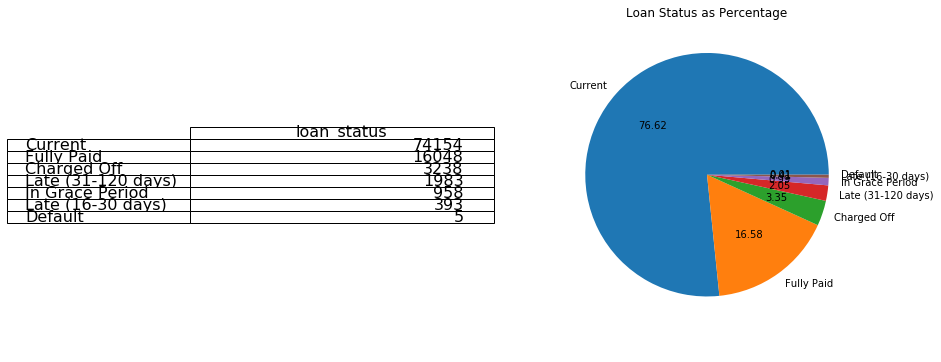

In [36]:
ls_vc = df.loan_status.value_counts()
print("Missing loan status:", df.loan_status.isnull().any())
plt.figure(figsize=(12,6)); 
ax1 = plt.subplot(122, aspect='equal'); ls_vc.plot.pie(ax=ax1, autopct='%.2f'); plt.ylabel(''); plt.title('Loan Status as Percentage');
ax2 = plt.subplot(121); plt.axis('off'); tbl = table(ax2, ls_vc, loc='center'); tbl.set_fontsize(16);

In [37]:
# convert loan_status column text to 1 and 0:
loan_status_c = lambda x: 1 if ((x == 'Charged Off') | (x == 'Default')) else 0
df.loan_status = df.loan_status.map(loan_status_c)

### loan_amount & installment
Plot of the Distribution of Loan Amount and Installment. They are numerical values, we can leave them as is.
This plot shows how much each month the borrower needs to replay. The mean is between 200 and 300.

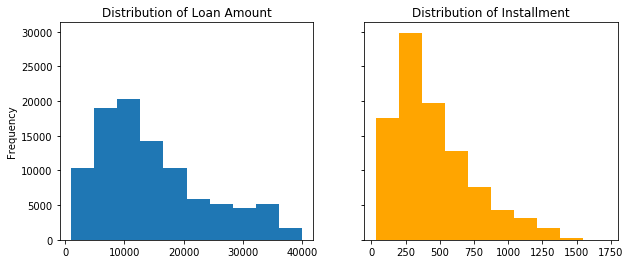

In [38]:
fig, ax = plt.subplots(figsize=(10,4))
plt.subplot(121, sharey=ax); df.loan_amnt.plot.hist(title='Distribution of Loan Amount');
plt.subplot(122, sharey=ax); df.installment.plot.hist(title='Distribution of Installment', color='orange');

### term
There are only 36 and 60 month loan terms. It is reasonable to leave term as a number, but strip the alpha part and keep only the number representing the length of the loan term.

Missing values: 0  Missing percent: 0.0


,term
60 months,24369
36 months,72410


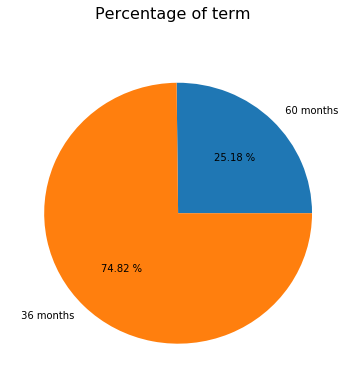

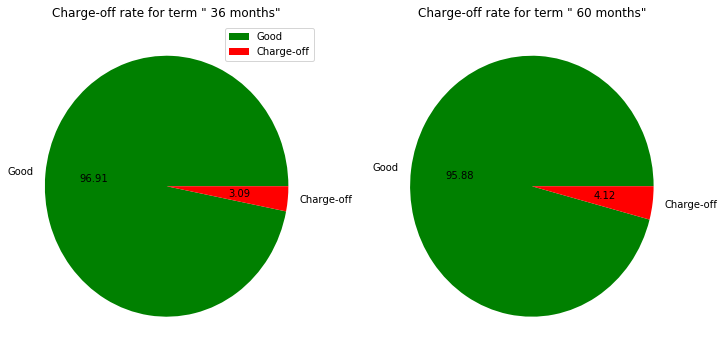

In [39]:
analyze_col(df, 'term', showgroups=True)

In [40]:
term_c = lambda x: 0 if x == ' 36 months' else 1 # np.int32(x.lstrip()[:2]) # keep the numerical part of term and convert to int
df.term = df.term.map(term_c)

### int_rate
Interest rate is a percentage value. We need to keep the float value of the string. The statistics for the interest rate are in the tables below. Overall the charge-off loans have higher mean interest rate of 17.45%, while the good loans have 13.23%. 

In [41]:
#converter
int_rate_c = lambda x: np.float32(x.strip('%')) # strip the percent sign from interest rate
df.int_rate = df.int_rate.map(int_rate_c)
print('Good loan Interest Rate statistics:')
display(pd.DataFrame(df[df.loan_status == 0].int_rate.describe()).T.round(2))
print('Charge-off loan Interest Rate statistics:')
display(pd.DataFrame(df[df.loan_status == 1].int_rate.describe()).T.round(2))

Good loan Interest Rate statistics:


,count,mean,std,min,25%,50%,75%,max
int_rate,93536.0,13.23,4.97,5.32,10.49,12.74,15.99,30.99


Charge-off loan Interest Rate statistics:


,count,mean,std,min,25%,50%,75%,max
int_rate,3243.0,17.45,6.07,5.32,12.74,15.99,19.99,30.99


The mean interest rate of charged-off loans are higher than good loans. This is evident from the box plot below:

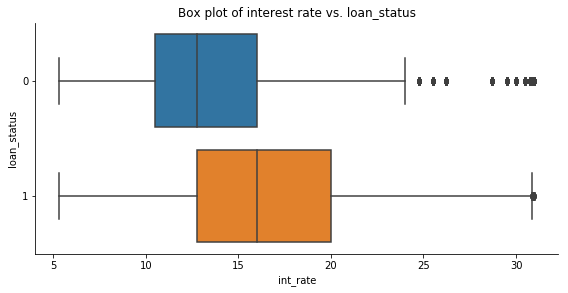

In [42]:
sns.factorplot(kind='box', orient='horizontal', x='int_rate', y='loan_status', aspect=2,
               data=df[['loan_status', 'int_rate']]); plt.title('Box plot of interest rate vs. loan_status');

The distributions of the interest rates are a little right squewd. This may need to be normalized. 

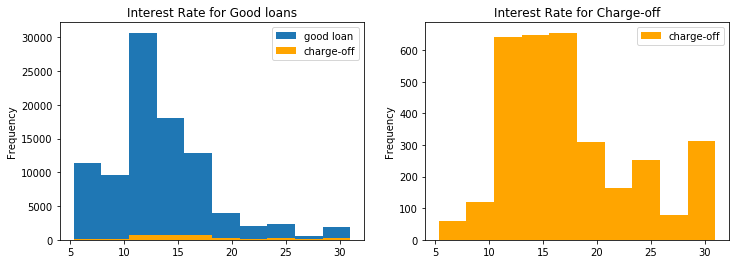

In [43]:
fig, ax = plt.subplots(figsize=(12, 4))
plt.subplot(121, sharey=ax); 
df[df.loan_status == 0].int_rate.plot.hist(); plt.title('Interest Rate for Good loans');
df[df.loan_status == 1].int_rate.plot.hist(color='orange'); 
plt.legend(labels=['good loan', 'charge-off']);
plt.subplot(122); 
df[df.loan_status == 1].int_rate.plot.hist(color='orange'); plt.title('Interest Rate for Charge-off');
plt.legend(labels=['charge-off']);

### grade & sub_grade
Loans are divided into sub-categores based on borrower rating. A is best and G is worst. I encode each grade as a number from 1 to 7.


Missing values: 0  Missing percent: 0.0


,grade
G,508
F,1735
E,5056
D,12029
A,14976
B,28776
C,33699


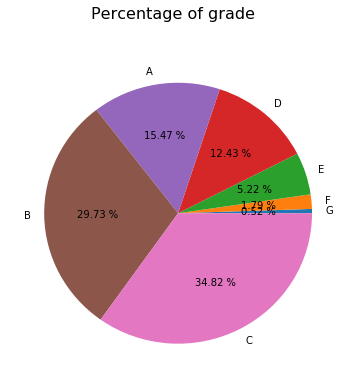

In [44]:
analyze_col(df, 'grade', showgroups=False)

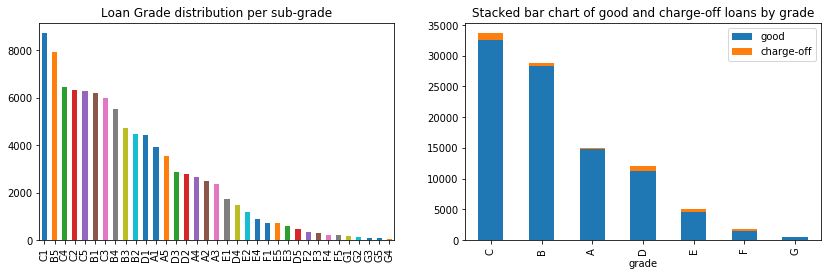

In [45]:
gls = df.groupby(['grade','loan_status']).size().unstack('loan_status').sort_values(by=0, ascending=False)
f, (ax1, ax2) = plt.subplots(1,2, figsize=(14,4))
df.sub_grade.value_counts().plot.bar(title='Loan Grade distribution per sub-grade', ax=ax1);
#df.grade.value_counts().plot.bar(title='Loan Grade distribution', ax=ax2);
gls.plot.bar(title='Stacked bar chart of good and charge-off loans by grade', stacked=True, ax=ax2); 
plt.legend(labels=['good', 'charge-off']); 

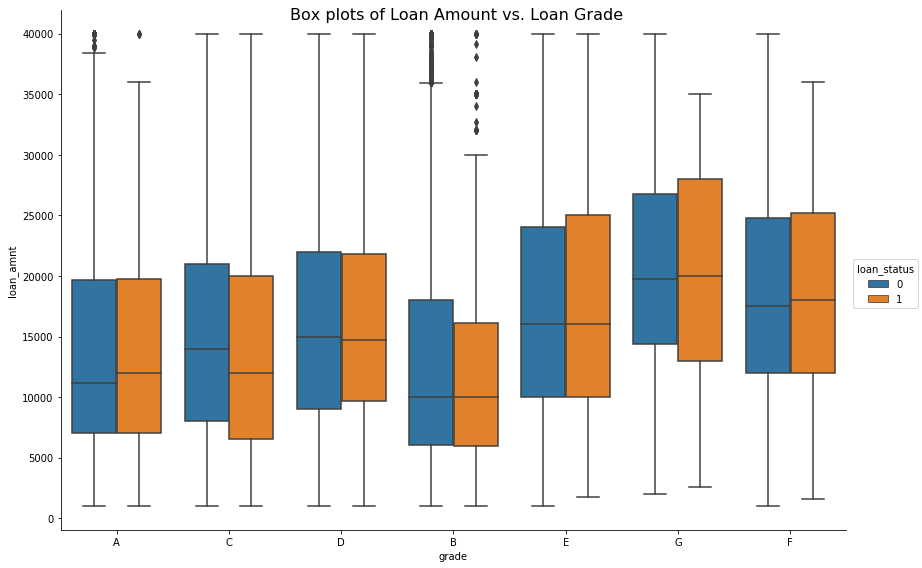

In [46]:
sns.factorplot(data=df, kind='box', y='loan_amnt', x='grade', hue='loan_status', hue_order=[0,1],
                size=8,  aspect=1.5); plt.suptitle('Box plots of Loan Amount vs. Loan Grade', fontsize=16);

The figure below shows how loan amounts vary across loan grade. Loan grade 7 corresponds to 'A' and is the best grade. We can see that the trend is that lower grade borrowers tend to borrows a higher amount. Charge-off status (orange) and good status are hard to tell apart by loan amount and grade.

We can see from the pie charts below that good loans have a much higher percentage of grade 'A' and 'B' loans than charge-off loans. Grade 'C' are represeted equally in both loan status. Since most loans are grade 'C' we can gain most by accurately predicting charge-off in grade 'C' loans.

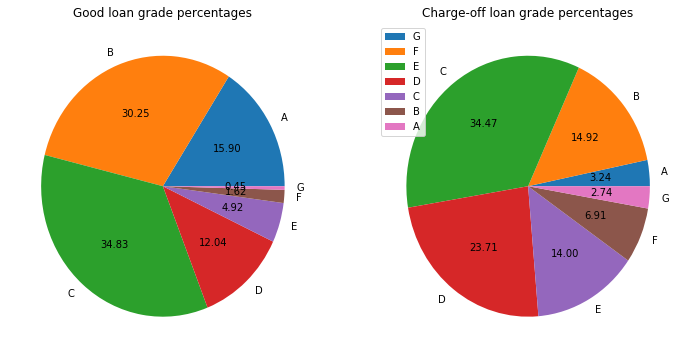

In [47]:
gls = df.groupby(['grade','loan_status']).size()
plt.subplots(12, figsize=(12, 6))
plt.subplot(121); 
gls.xs(0, level=1).plot.pie( autopct='%.2f');
plt.ylabel(''); plt.title('Good loan grade percentages');

plt.subplot(122); 
gls.xs(1, level=1).plot.pie( autopct='%.2f');
plt.legend(labels=['G','F', 'E', 'D', 'C', 'B', 'A'], loc=2);plt.ylabel('');plt.title('Charge-off loan grade percentages');


In [48]:
# converter:
grade_d = {'A': 7, 'B': 6, 'C': 5, 'D': 4, 'E': 3, 'F':2, 'G': 1}
grade_c = lambda x: grade_d.get(x)
df.grade = df.grade.map(grade_c)

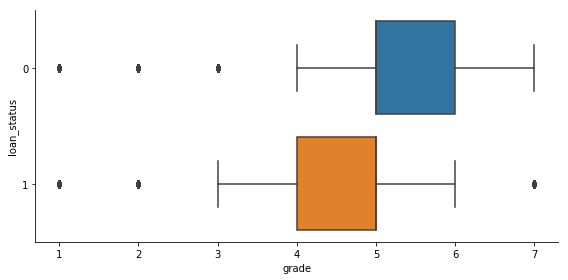

In [49]:
sns.factorplot(kind='box', orient='horizontal', 
               x='grade', y='loan_status', aspect=2,
               data=df[['loan_status', 'grade']]); 

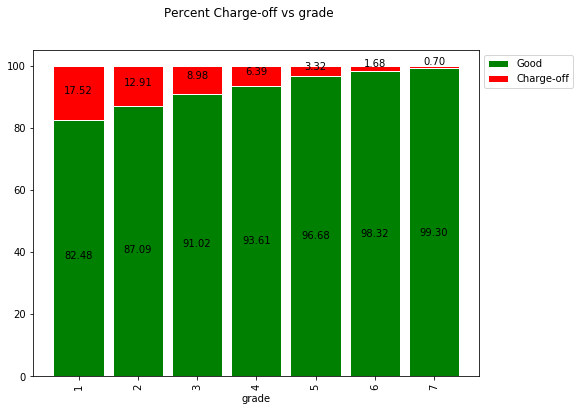

In [50]:
percent_col(df, 'grade')

### emp_length
About one third of the loans were given to individuals with 10+ years of employment. The other 2/3 are given in a much lower proportion to shorter term. 10+ is a collective buckes as includes employment lenghts of 11, 12, 15, 20 up to retirement. I encode employment length with the number of years, where the label is the year. 10+ years is encoded as 12, < 1 year is 0.5, and where not available it is 0.

In [51]:
col = 'emp_length'
df[col] = X[col]
df.emp_length.isnull().sum()

6792

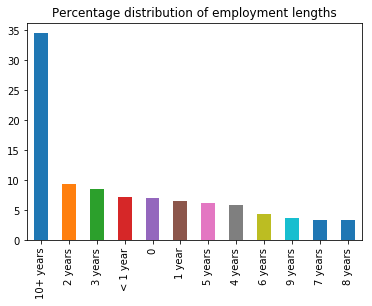

In [52]:
# Encode emp_length: number to number and NaN to 0
df.emp_length.fillna('0', inplace=True)

eld = round(df.emp_length.value_counts()/len(df)*100,1)
eld.plot.bar(title='Percentage distribution of employment lengths');

Missing values: 0  Missing percent: 0.0


,emp_length
8 years,3199
7 years,3222
9 years,3580
6 years,4248
4 years,5727
5 years,6042
1 year,6421
0,6792
< 1 year,6951
3 years,8180


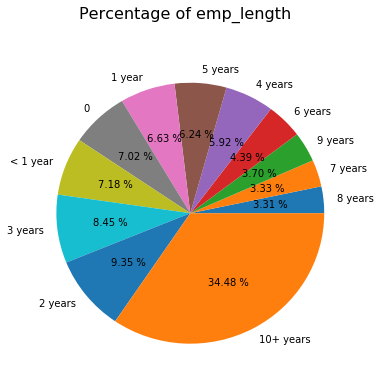

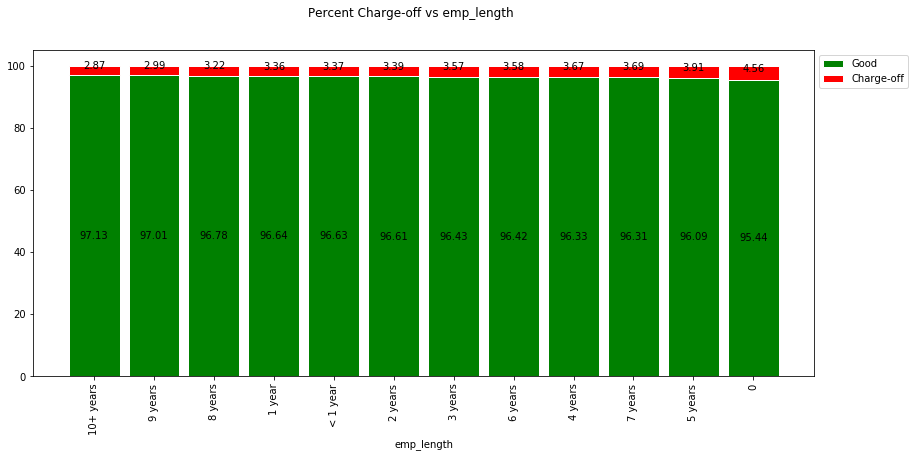

In [53]:
analyze_col(df,'emp_length', showgroups=False)
percent_col(df, 'emp_length', figsize=(14, 6))

In [54]:
# converter:
#import re
#[ re.search(r'\d+', s).group() for s in df.emp_length.unique()]
emp_len_m = {'10+ years':12, '3 years': 3, '6 years': 6, '0':0, np.nan: 0, '< 1 year': 0.5, '1 year': 1,
       '4 years':4, '8 years':8, '2 years':2, '5 years':5, '9 years':9, '7 years':7}
df.emp_length = df.emp_length.map(emp_len_m)

### home_ownership
About half of the loan recipients pay mortgage, compared to renting, owning or other. It begs to ask how much money borrowers have left over after paying their mortgages? It seems reasonable to think that people with a long a reliable mortgage history may have higher rating. It will be worth investigating correlation between Home Ownership and other features. Also does NONE mean that a borrower is homeless? Other features such as car ownership would be useful to know: a person may default on other loans before a car loan.
    

In [55]:
col = 'home_ownership'
#df[col] = X[col]
# encode
print("Missing home ownership:", df[col].isnull().sum())
#df.home_ownership.fillna('ANY', inplace=True)
#df.home_ownership.fillna('MORTGAGE', inplace=True)


Missing home ownership: 0


In [56]:
df.loc[df[col] == 'NONE', col] = 'ANY'

Missing values: 0  Missing percent: 0.0


,home_ownership
ANY,382
OWN,11135
RENT,37179
MORTGAGE,48083


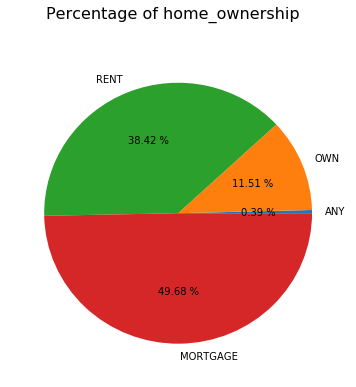

In [57]:
analyze_col(df, 'home_ownership')

In [58]:
# convert to dummies and drop column
df = dummies(df, 'home_ownership', 'home_own')

### annual_inc
The annual income is perhaps one of the pivotal features. It is worth taking a deeper look. The histogram below shows income distribution in the \$0-200k range. There appears to be spurious data, for illustration see the table. There is a  borrower with income \$61 million and emp_title indicated waitress. There is some data that is suspicious and unlikely. It may be worth asking LC a few questions about their verification process! 
Also, it appears as if there were three nested distributions, I am not sure if it is real.

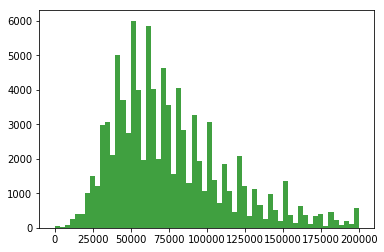

In [59]:
plt.hist((df.annual_inc), 60, range=(0, 200000), facecolor='g', alpha=0.75);

The box plots below illustrate the annual income ranges. The outlies are identified by the IQR as incomes above about $200k. 

AttributeError: 'DataFrame' object has no attribute 'annual_inc'

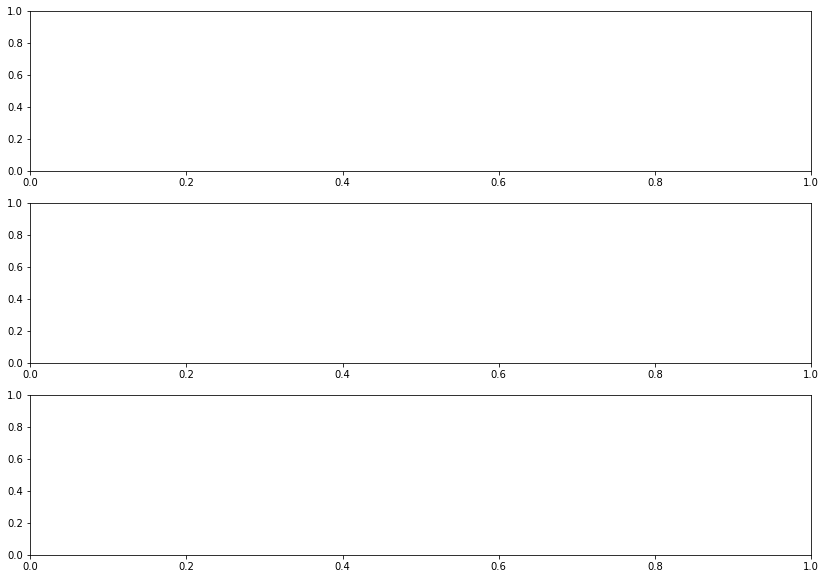

In [130]:
fig, axes = plt.subplots(3,1,figsize=(14,10))
plt.subplot(311)
plt.title='Income distribution'
df.annual_inc.plot.box(vert=False, title='Box plot of unadjusted income range');


#plt.subplot(412)
#df[df.annual_inc < 2e6].annual_inc.plot.box(vert=False, title='Box plot of income range $0-2M');

plt.subplot(313)
df[df.annual_inc < 2e5].annual_inc.plot.box(vert=False, title='Box plot of income range $0-200k');

plt.subplot(313)
plt.violinplot(df[df.annual_inc < 2e5].annual_inc, vert=False);
plt.xlabel('Violin plot of income range $0-200k');
plt.tight_layout()


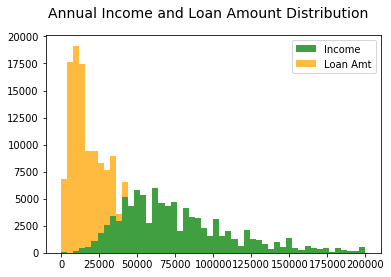

In [61]:
a,b,c = plt.hist((df.annual_inc, df.loan_amnt), 50, color=['g','orange'], 
                histtype='barstacked', stacked=True, range=(0, 200000), alpha=0.75)
plt.suptitle('Annual Income and Loan Amount Distribution', fontsize=14);
plt.legend(['Income', 'Loan Amt']);

The table below shows emp_title and annual income for borrowers with annual income > \$200k who defaulted. High income is not a guarantee for loan repayment.

In [62]:
df[(df.loan_status == 1) & (df.annual_inc > 2e5)][['annual_inc', 'grade', 'emp_title', 'verification_status']].sort_values('annual_inc')

,annual_inc,grade,emp_title,verification_status
60789,205000.0,5,Licensed loan officer,Verified
4287,208000.0,5,Senior Consultant,Source Verified
62558,208000.0,3,Physician,Verified
72931,210000.0,4,General Manager,Source Verified
89676,210000.0,5,Assistant General Counsel,Source Verified
72198,210000.0,5,owner,Source Verified
15246,210000.0,7,President,Verified
15559,210000.0,2,Sales,Verified
42415,211200.0,5,Senior Accountant,Source Verified
46155,211400.0,4,Director,Source Verified


In [63]:
print("Number of borrowers with income equal to zero:", len(df[df.annual_inc == 0]))
print("Number of borrowers making more than a million:", len(df[df.annual_inc > 1e6]))


Number of borrowers with income equal to zero: 31
Number of borrowers making more than a million: 21


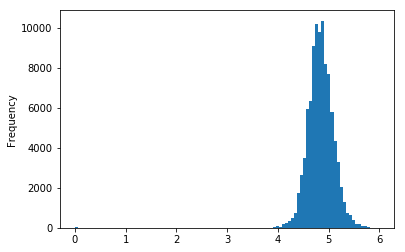

In [64]:
# Transform annual income:
# some joint borrowers' annual income is zero. In order to log normalize it we need to change zero to a very small number, like 1.
ind = df[df.annual_inc == 0].index 
df.loc[ind, 'annual_inc'] = 1

#I will drop rows with annual_inc > 1 million
df = df[df.annual_inc < 1000000]

np.log10(df.annual_inc).plot.hist(bins=100);
#df.annual_income = np.log10(df.annual_inc)

### application_type
Some borrower borrow jointly with other individuals. The joint status type of the loan is indicated by this field.

Missing values: 0  Missing percent: 0.0


,application_type
Joint App,4406
Individual,92350


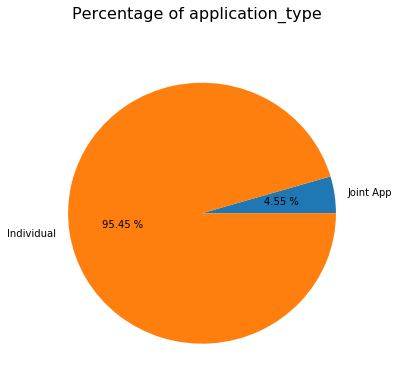

In [65]:
analyze_col(df, 'application_type', )

In [66]:
# encode application_type
df.application_type = df.application_type.map({'Individual': 1, 'Joint App': 0})

### annual_inc_joint
Some borrower borrow jointly. If the borrower is an individual, the annual_inc_joint field is NaN, so we fill it with 1 so that we can log normalize it.

In [67]:
# copy values from annual_inc over to annual_inc_joint
df.annual_inc_joint.fillna(df.annual_inc, inplace=True)
print("Mislabeled application type count:", len(df[(df.annual_inc_joint == 1) & (df.application_type == 0)]))
print('Sample date showing annual_inc and annual_inc_joint for Joint App');
idx = df[df.application_type == 0].index
display(df.loc[idx, ['annual_inc', 'annual_inc_joint', 'application_type']].head(5));

Mislabeled application type count: 0
Sample date showing annual_inc and annual_inc_joint for Joint App


,annual_inc,annual_inc_joint,application_type
113,100000.0,135000.0,0
118,90000.0,100000.0,0
139,31872.0,123471.0,0
146,35000.0,79500.0,0
164,102000.0,152000.0,0


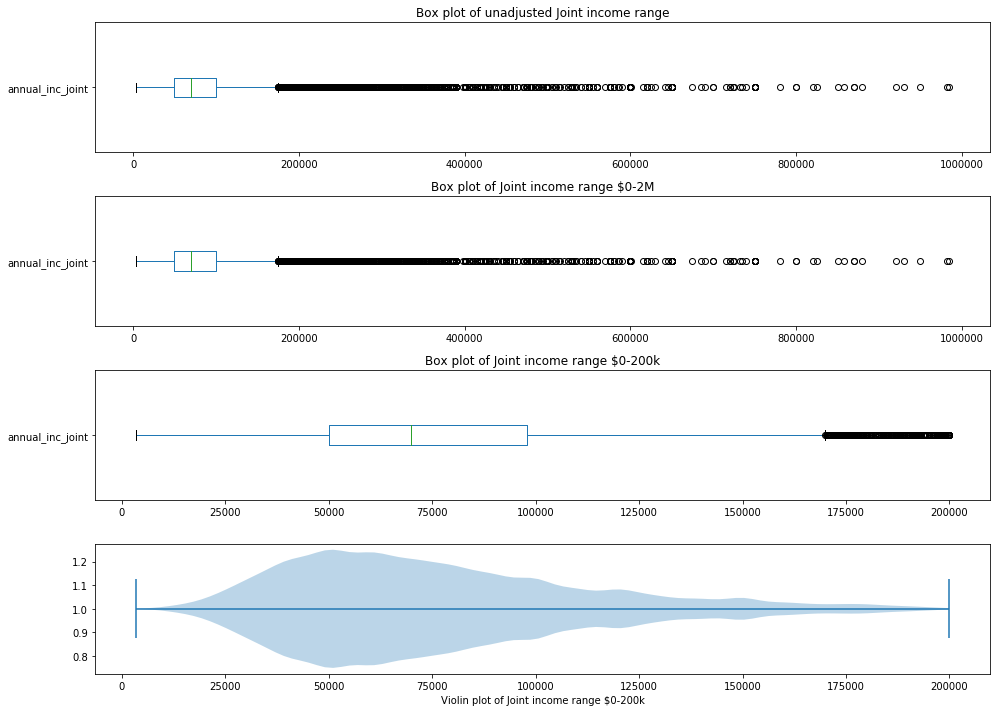

In [68]:
fig, axes = plt.subplots(4,1,figsize=(14,10))
plt.subplot(411)
plt.title='Income distribution'
df.annual_inc_joint.plot.box(vert=False, title='Box plot of unadjusted Joint income range');

plt.subplot(412)
df[df.annual_inc_joint < 2e6].annual_inc_joint.plot.box(vert=False, title='Box plot of Joint income range $0-2M');

plt.subplot(413)
df[df.annual_inc_joint < 2e5].annual_inc_joint.plot.box(vert=False, title='Box plot of Joint income range $0-200k');

plt.subplot(414)
plt.violinplot(df[df.annual_inc_joint < 2e5].annual_inc_joint, vert=False);
plt.xlabel('Violin plot of Joint income range $0-200k');
plt.tight_layout()

It looks like the best option id to use the joint income. There the zero income problem goes away and the distibution looks nice and centered.

In [69]:
# convert
df.annual_inc_joint = np.log10(df.annual_inc_joint)

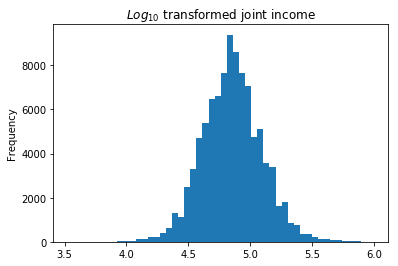

In [70]:
df.annual_inc_joint.plot.hist(bins=50, title=r'$Log_{10}$ transformed joint income'); 

### emp_title
The output below shows that about 7% of loans have no employment title. This may be indicative. It may be worth encoding it a title/no title. There is a very large number of different titles, one out of three loans have a unique employment title. Missing employee title has a little higher charge-off rate.

In [71]:
print("Percent of missing job title:", round(len(df[df.emp_title.isnull()])/len(df)*100, 2) )
print("Percentage of unique titles:", round(len(df.emp_title.unique()) / len(df) * 100, 2))

Percent of missing job title: 7.12
Percentage of unique titles: 36.69


In [72]:
# encode 
col = 'emp_title'
df[col] = X[col]
df[col] = df[col].apply(emp_title_c)


Missing values: 0  Missing percent: 0.0


,emp_title
1,6892
0,89864


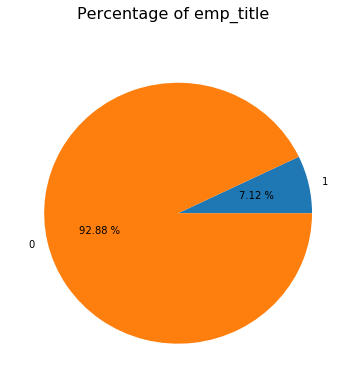

In [73]:
analyze_col(df, 'emp_title')

### verification_status
Indicates if income was verified by LC, not verified, or if the income source was verified. It can take on values 'Source Verified', 'Not Verified', 'Verified'. Below pie plot shows surpisingly that Verified status is charged off at a higher rate than 'Source Verified', 'Not Verified'. The values need to be one-hot encoded.

Missing values: 0  Missing percent: 0.0


,verification_status
Verified,27540
Not Verified,31014
Source Verified,38202


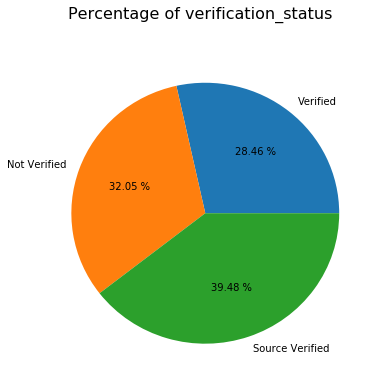

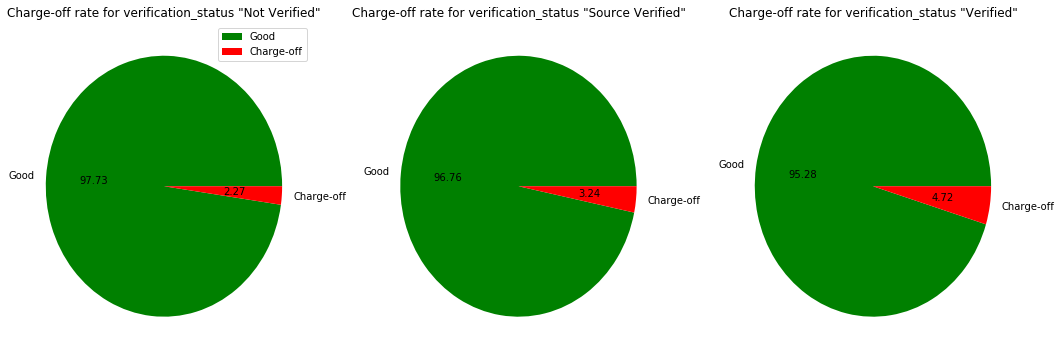

In [74]:
analyze_col(df, 'verification_status', showgroups=True)


In [75]:
# look at correlation vs. loan amt, grade, 

In [76]:
# convert to dummies and drop column


### verification_status_joint
Indicates if income was verified by LC, not verified, or if the income source was verified. It can take on values 'Source Verified', 'Not Verified', 'Verified'. Below pie plot shows surpisingly that Verified status is charged off at a higher rate than 'Source Verified', 'Not Verified'. The values need to be one-hot encoded.

In [77]:
df.verification_status.unique()

array(['Not Verified', 'Verified', 'Source Verified'], dtype=object)

Missing values: 92350  Missing percent: 0.9544627723345323


,verification_status_joint
Source Verified,320
Verified,337
Not Verified,3749


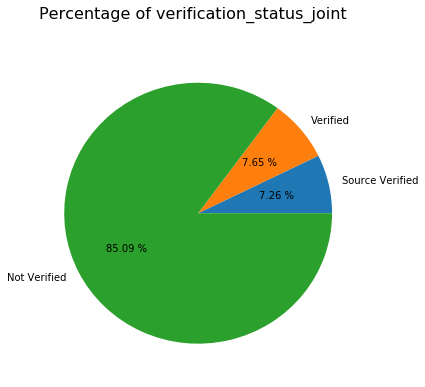

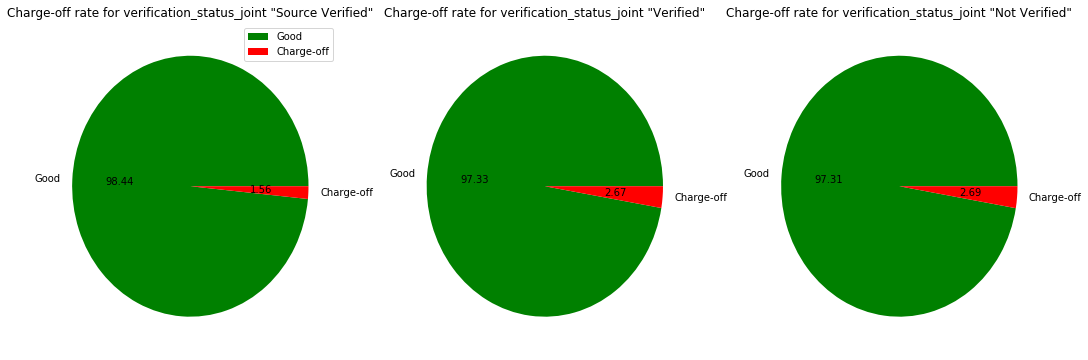

In [78]:
col = 'verification_status_joint'
df[col] = X[col]
analyze_col(df, col, showgroups=True)

In [79]:
df.verification_status_joint.fillna(df.verification_status, inplace=True)
#analyze_col(df, 'verification_status_joint', showgroups=True)

In [80]:
# convert to dummies and drop column
df = dummies(df, 'verification_status_joint', 'ver_stat_joint')
df = dummies(df, 'verification_status', 'ver_stat')

### pymnt_plan
Indicates if a payment plan has been put in place for the loan. Since most loans have no payment plan, this column is not very informative. I'll drop it.

Missing values: 0  Missing percent: 0.0


,pymnt_plan
y,63
n,96693


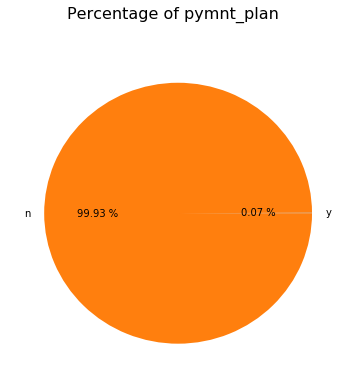

In [81]:
analyze_col(df, 'pymnt_plan')

### purpose

Missing purpose value: False
Missing values: 0  Missing percent: 0.0


,purpose
renewable_energy,68
house,429
moving,704
vacation,780
car,1118
small_business,1145
medical,1353
major_purchase,2171
other,6131
home_improvement,7055


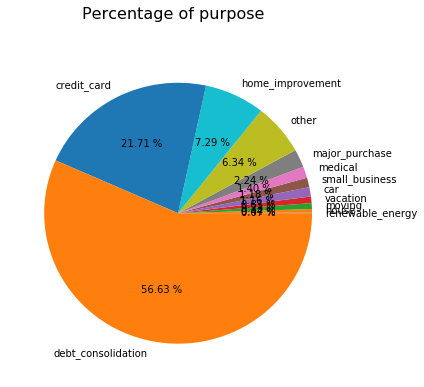

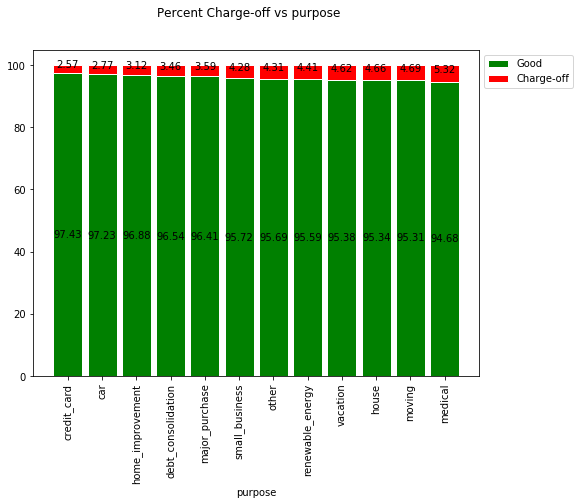

In [82]:
print("Missing purpose value:", df.purpose.isnull().any())
analyze_col(df, 'purpose', showgroups=False)
percent_col(df, 'purpose')
# group together renewable, 
# look at mean loan amt vs. purpose

In [83]:
df[(df['purpose'] == 'vacation') & (df.loan_status == 1)][['loan_amnt']].mean()

loan_amnt    7022.916504
dtype: float32

In [84]:
# we need to encode the purpose
df = dummies(df, 'purpose', 'purpose')

### zip_code
The zip codes will be reduced to the first two digits of the zip code. They may have to be dropped if it does not work out. The heatmap below shows the various charge-off rates by zip code. A geographic map visualization would be also useful and informative. Missing values are filled in with the most common value.

In [85]:
# most common zip code
mcz = df.zip_code.value_counts().sort_values(ascending=False).index.values[0]
df.zip_code.fillna(mcz, inplace=True)
# encode:
df.zip_code = [int(s[:2]) for s in df.zip_code]

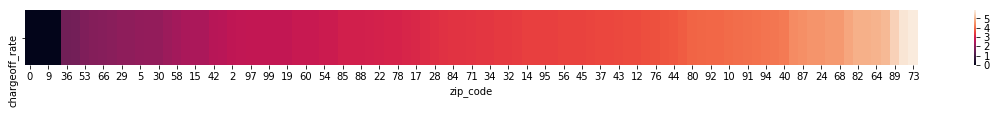

In [86]:
cr = chargeoff_rank(df, 'zip_code')
plt.figure(figsize=(20,1)); sns.heatmap(cr.T);

### dti
Debt to income ratio. dti for individuals with zero income is NaN, so we need to impute missing values. Borrowers with zero income are applying jointly. I will supply the missing value for dti from dti_joint. [Feature Index](#Features) 

In [87]:
print("Imputing missing dti for Joint borrowers with no income: %.2f" % len(df[(df.application_type == 0) & (df.dti.isnull())]))
df.dti.fillna(df.dti_joint, inplace=True)

Imputing missing dti for Joint borrowers with no income: 33.00


Missing values for dti 0


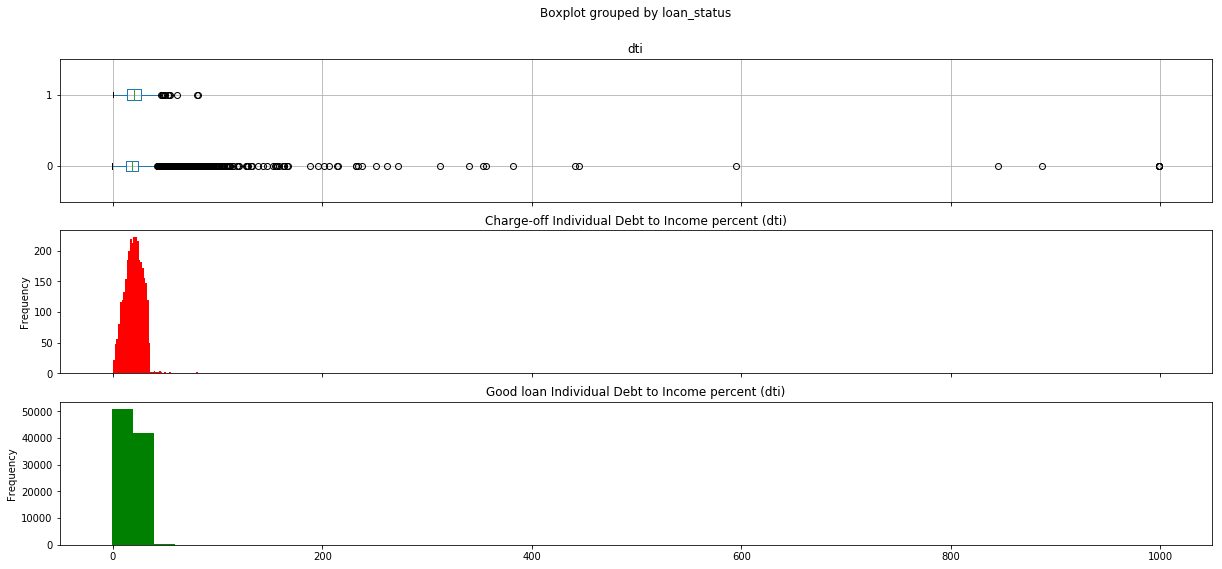

In [88]:
plot_box_hist2(df, 'dti', title='Individual Debt to Income percent', bins=50)

### dti_joint
Debt to income ratio for joint borrowers. dti_joint for individuals is NaN, so we need to impute missing values. I will supply the missing value for dti_joint for individualt from dti_joint. This feature is distributed better than dti, so I will use this feature instead of dti. [Feature Index](#Features) 

In [89]:
print("Imputing missing dti for Joint borrowers with no income: %.2f" % len(df[(df.application_type == 1) & (df.dti_joint.isnull())]))
df.dti_joint.fillna(df.dti, inplace=True)

Imputing missing dti for Joint borrowers with no income: 92350.00


Missing values for dti_joint 0


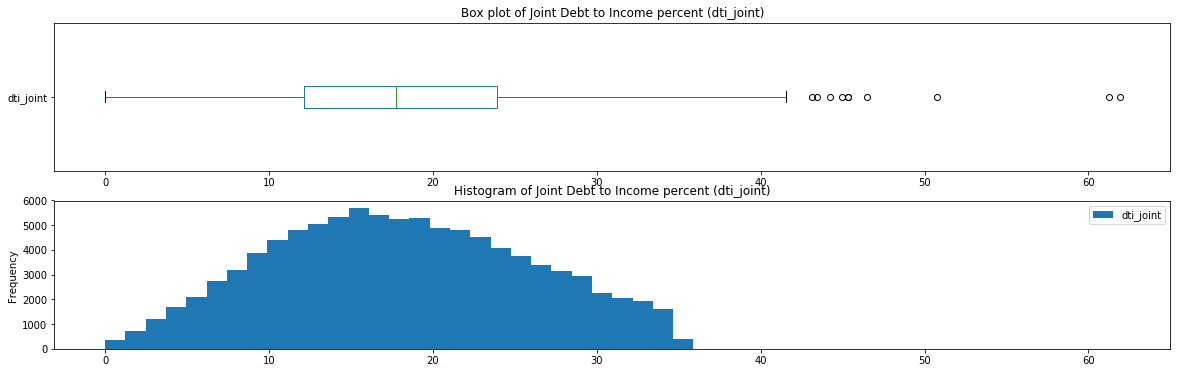

In [90]:
plot_box_hist(df, 'dti_joint', title='Joint Debt to Income percent', bins=50)

### delinq_2yrs
This feature indicates the number of times the borrower was delinquent in the last 2 years. About 80% of borrowers had 0 delinquencies, 14% one delinquency.
[Feature Index](#Features) 

Number of missing values of delinq_2yrs: 0
Missing values: 0  Missing percent: 0.0


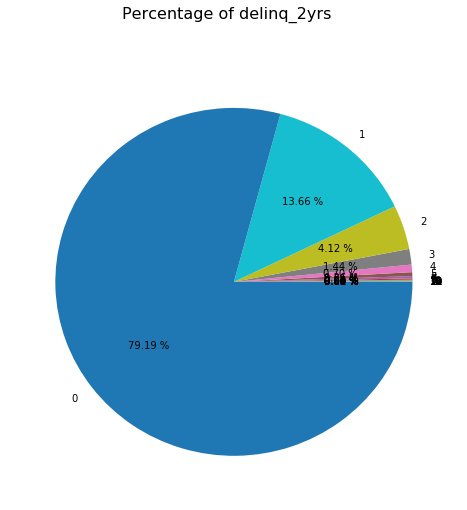

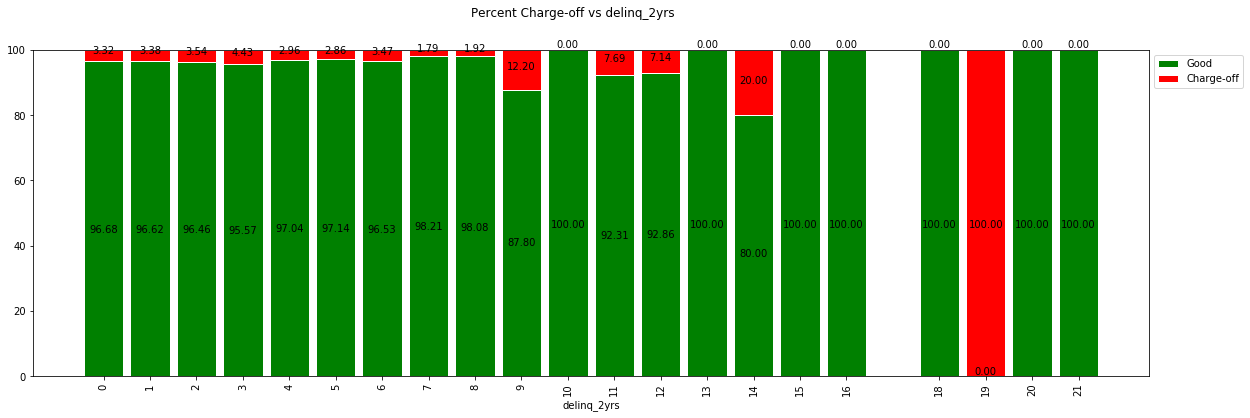

In [91]:
print("Number of missing values of delinq_2yrs: %s" % sum(df.delinq_2yrs.isnull()))
analyze_col(df, 'delinq_2yrs', showtable=False, showgroups=False, piesize=(8, 8))
percent_col(df, 'delinq_2yrs', figsize=(20,6))

### issue_d
[Feature Index](#Features) 

In [92]:
print("Number of missing issue_d: %d " % sum( df['issue_d'].isnull()))
display(df.issue_d.head(5))
is_d = pd.to_datetime(df.issue_d, format='%b-%Y')


Number of missing issue_d: 0 


0    Mar-2017
1    Mar-2017
2    Mar-2017
3    Mar-2017
4    Mar-2017
Name: issue_d, dtype: object

### earliest_cr_line
[Feature Index](#Features) 

In [93]:
display(df.earliest_cr_line.head(5))
print("Number of missing earliest_cr_line: %d " % sum( df['earliest_cr_line'].isnull()))
ecl = pd.to_datetime(df.earliest_cr_line, format='%b-%Y')
# create new feature as the length of credit history in years
cr_history = (is_d - ecl).astype('timedelta64[Y]')
df['cr_history'] = cr_history


0    Nov-1974
1    Oct-2005
2    Aug-2002
3    Jul-1995
4    Oct-2007
Name: earliest_cr_line, dtype: object

Number of missing earliest_cr_line: 0 


### cr_history
This is an engineered feature, it indicates the length of credit history of an individual. It is calculated as the time difference in years of issue_d - earliest_cr_line. There does not appear to be a strong correlation between it and charge-off rate.
[Feature Index](#Features) 

Missing values: 0  Missing percent: 0.0


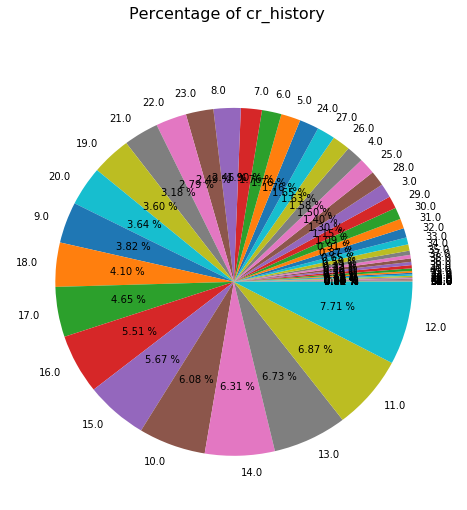

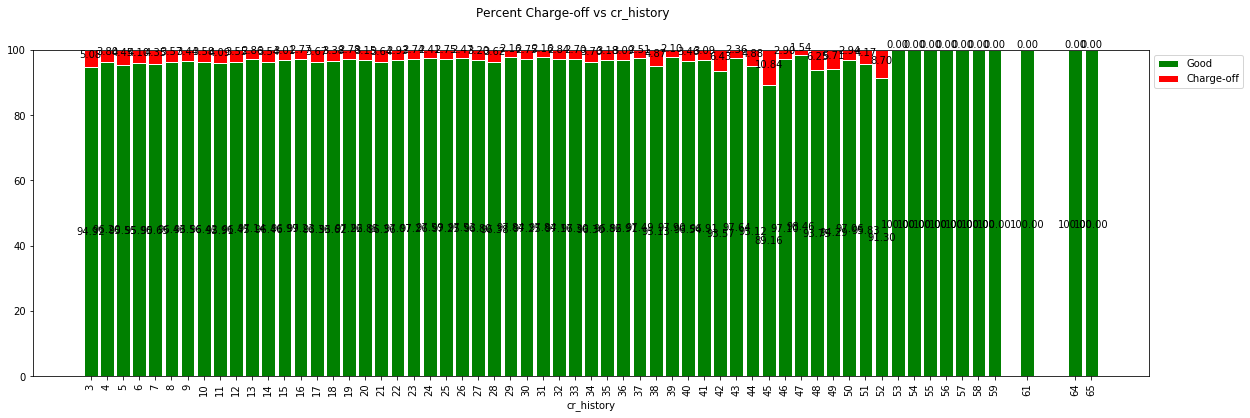

In [94]:
analyze_col(df, 'cr_history', showtable=False, showgroups=False, piesize=(8, 8))
percent_col(df, 'cr_history', figsize=(20, 6))

### fico_range_low
[Feature Index](#Features) 

In [95]:
print("We can see that there was a cutoff for applicant at a FICO rate of", min(df.fico_range_low))

We can see that there was a cutoff for applicant at a FICO rate of 660


Missing values for fico_range_low 0


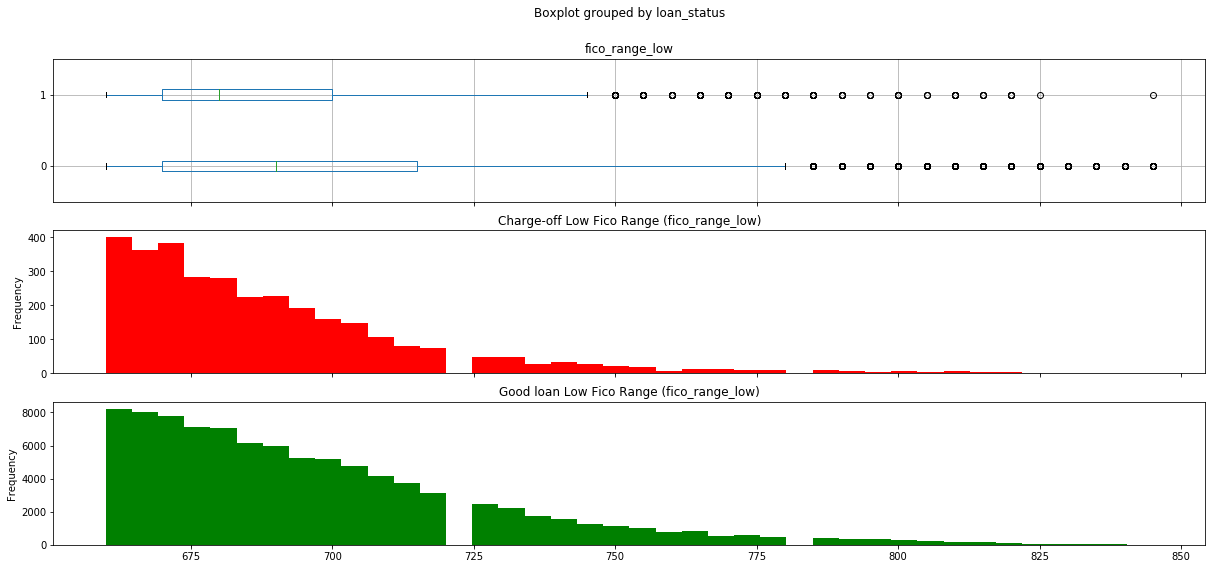

In [96]:
plot_box_hist2(df, 'fico_range_low', title='Low Fico Range', bins=40)

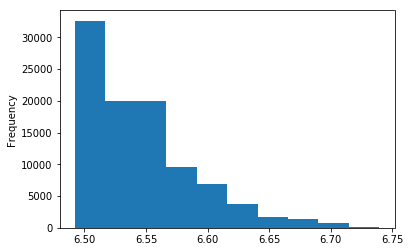

In [97]:
np.log(df.fico_range_low).plot.hist();

### fico_range_high
[Feature Index](#Features) 

Missing values for fico_range_high 0


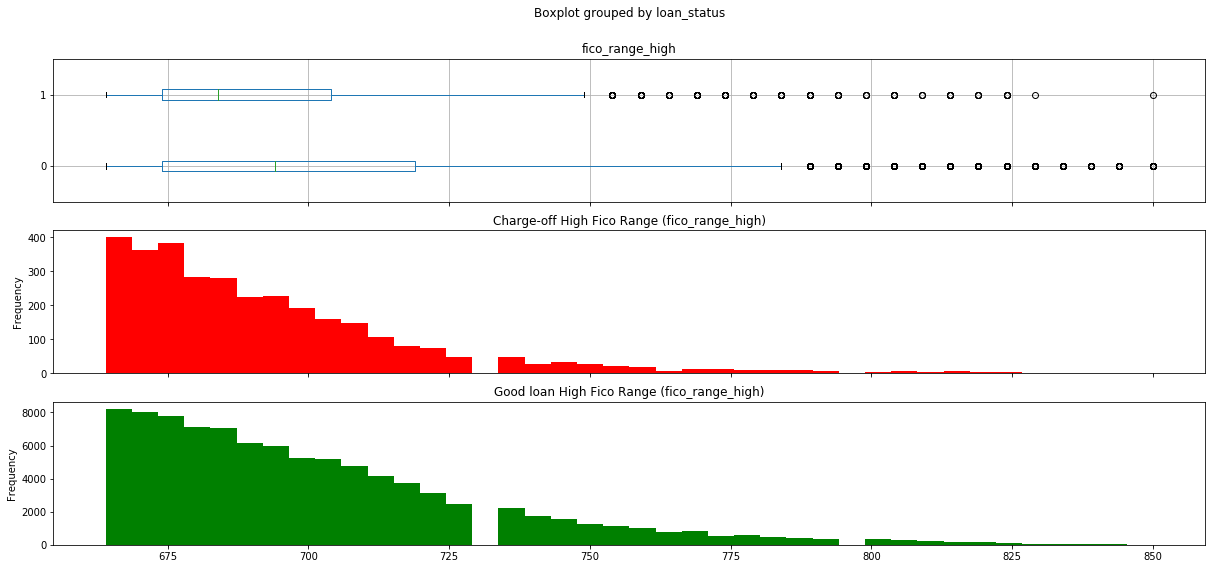

In [98]:
plot_box_hist2(df, 'fico_range_high', title='High Fico Range', bins=40)

### fico_range_mean
May convert to categorical

[Feature Index](#Features) 

Missing values for fico_range_mean 0


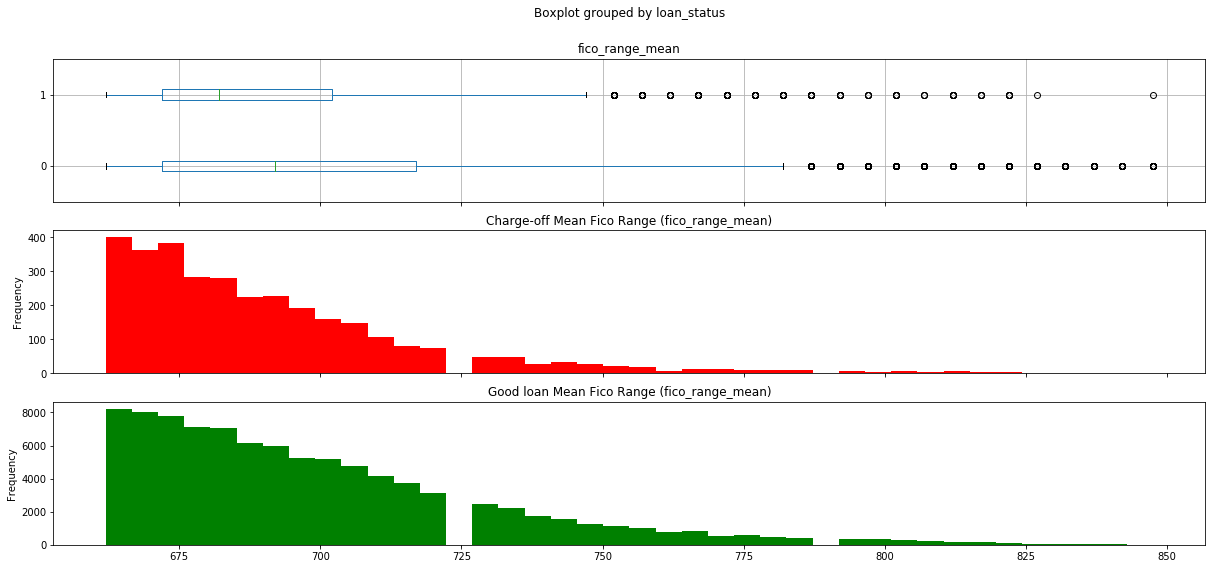

In [99]:
df['fico_range_mean'] = df[['fico_range_high', 'fico_range_low']].mean(1)
plot_box_hist2(df, 'fico_range_mean', title='Mean Fico Range', bins=40)

### last_fico_range_high
The upper boundary range the borrower’s last FICO pulled belongs to. It is worth noting how much the FICO rate drops for charge-off loans over time! It lends itself to feature interaction study, taking the difference of FICO score and last FICO score. 

[Feature Index](#Features) 

Missing values for last_fico_range_high 0


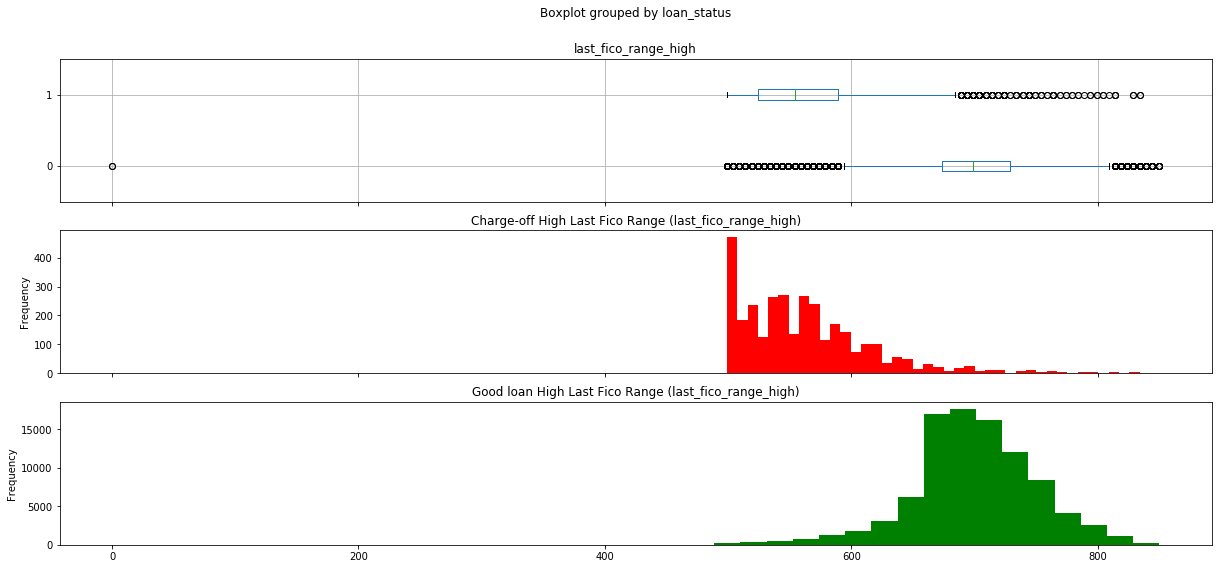

In [100]:
col = 'last_fico_range_high'
#df[col] = X[col]
plot_box_hist2(df, col, title='High Last Fico Range', bins=40)

In [101]:
# fix data error where last_fico_range_high = 0
ind = df[df['last_fico_range_high'] == 0].index
df.loc[ind,'last_fico_range_high'] = df['last_fico_range_high'].median()

### last_fico_range_low
[Feature Index](#Features) 

Missing values for last_fico_range_low 0


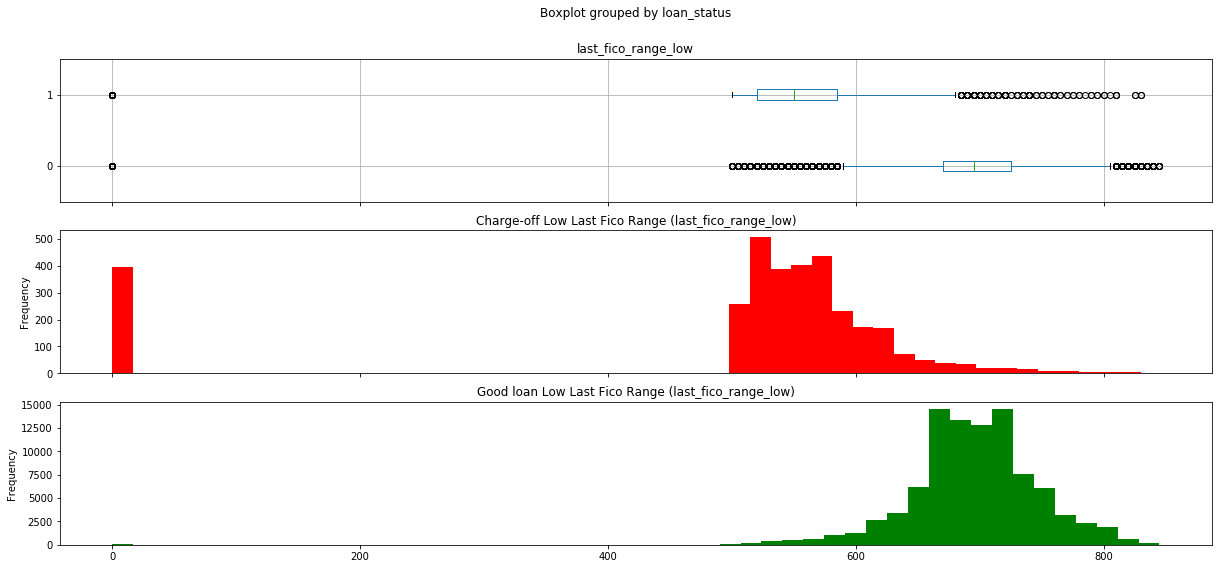

In [102]:
col = 'last_fico_range_low'
df[col] = X[col]
plot_box_hist2(df, col, title='Low Last Fico Range', bins=50)

Change of mean value last_fico_range_low for charge-off loans: -120.15560787286267
Change of mean value last_fico_range_low for good loans: -1.2458135411690137
Missing values for last_fico_range_low 0


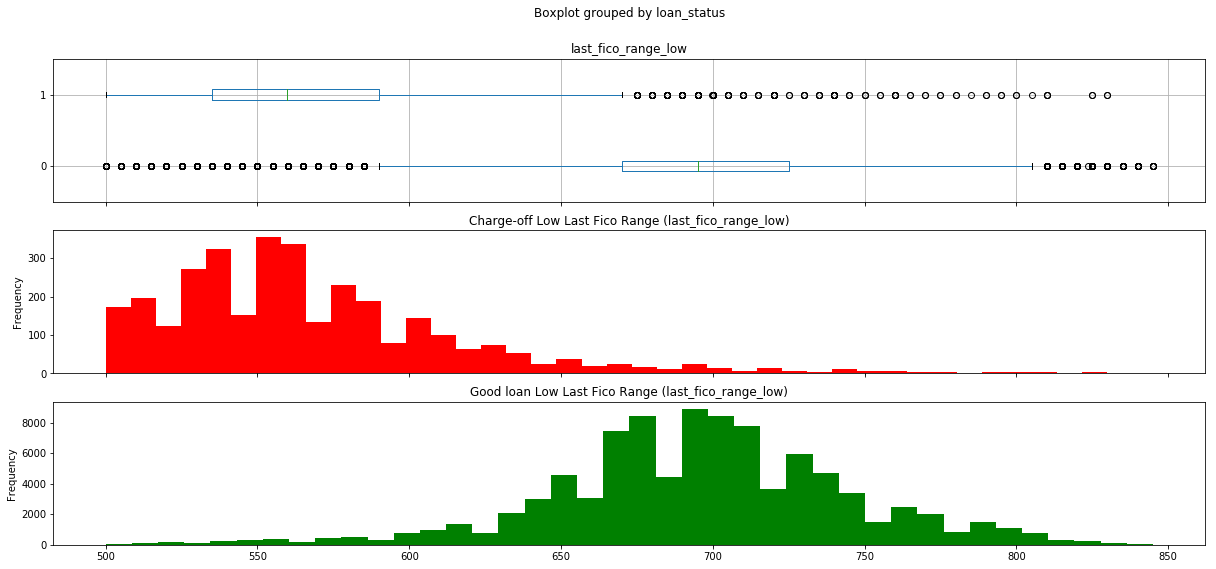

In [103]:
#####
# charge-off shift:
# mean last_fico_range_low
m_lfl = df[(df['loan_status'] == 1) & (df['last_fico_range_low'] > 0)]['last_fico_range_low'].mean()

m_fl = df[df['loan_status'] == 1]['fico_range_low'].mean()
diff1 = m_lfl - m_fl
print("Change of mean value last_fico_range_low for charge-off loans:", diff1)

# good loan shift:
# mean last_fico_range_low
m_lfl = df[(df['loan_status'] == 0) & (df['last_fico_range_low'] > 0)]['last_fico_range_low'].mean()
m_fl = df[df['loan_status'] == 0]['fico_range_low'].mean()
diff0 = m_lfl - m_fl
print("Change of mean value last_fico_range_low for good loans:", diff0)

#####
# adjust mislabeled data:
# charge-off
ind1 = df[(df['loan_status'] == 1) & (df['last_fico_range_low'] == 0)].index
df.loc[ind1, 'last_fico_range_low'] = df.loc[ind1, 'fico_range_low'] + diff1

# good loan:
ind0 = df[(df['loan_status'] == 0) & (df['last_fico_range_low'] == 0)].index
df.loc[ind0, 'last_fico_range_low'] = df.loc[ind0, 'fico_range_low'] + diff0

# plot to re-check values:
plot_box_hist2(df, col, title='Low Last Fico Range', bins=40)

### last_fico_range_mean
Mean of high and low values

[Feature Index](#Features) 

Missing values for last_fico_range_mean 0


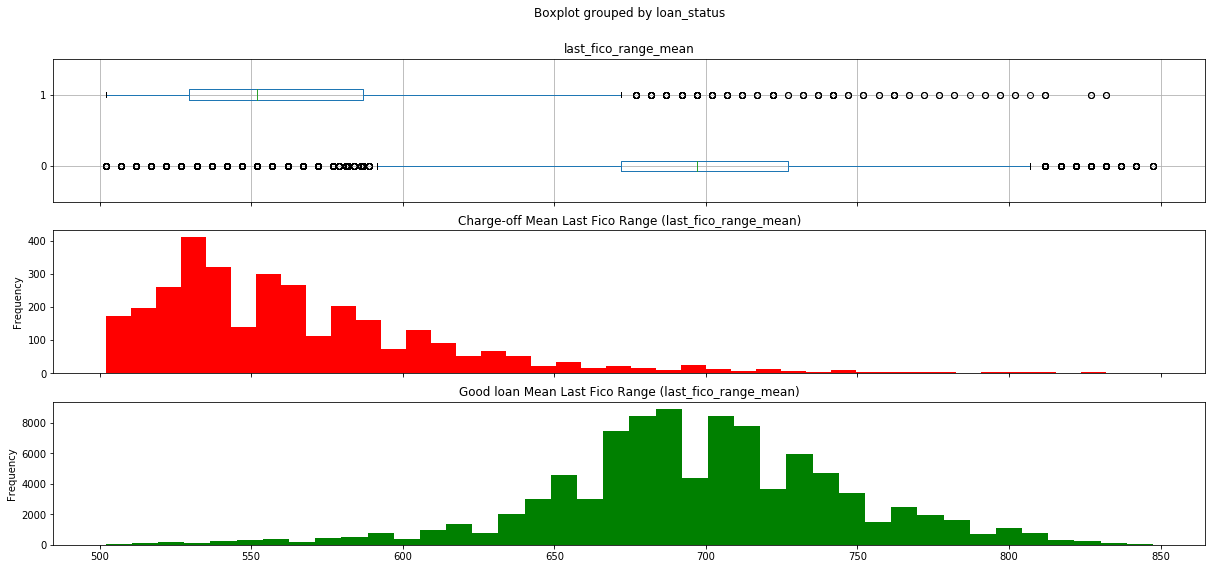

In [104]:
col = 'last_fico_range_mean'
df['last_fico_range_mean'] = df[['last_fico_range_high', 'last_fico_range_low']].mean(1)
plot_box_hist2(df, col, title='Mean Last Fico Range', bins=40)

### fico_mean_diff
Engineered feature: the difference between the mean FICO and LAST FICO values. It shows by how much the FICO score shifted over time for charge-off and non-charge off loans.

[Feature Index](#Features) 

Missing values for fico_mean_diff 0


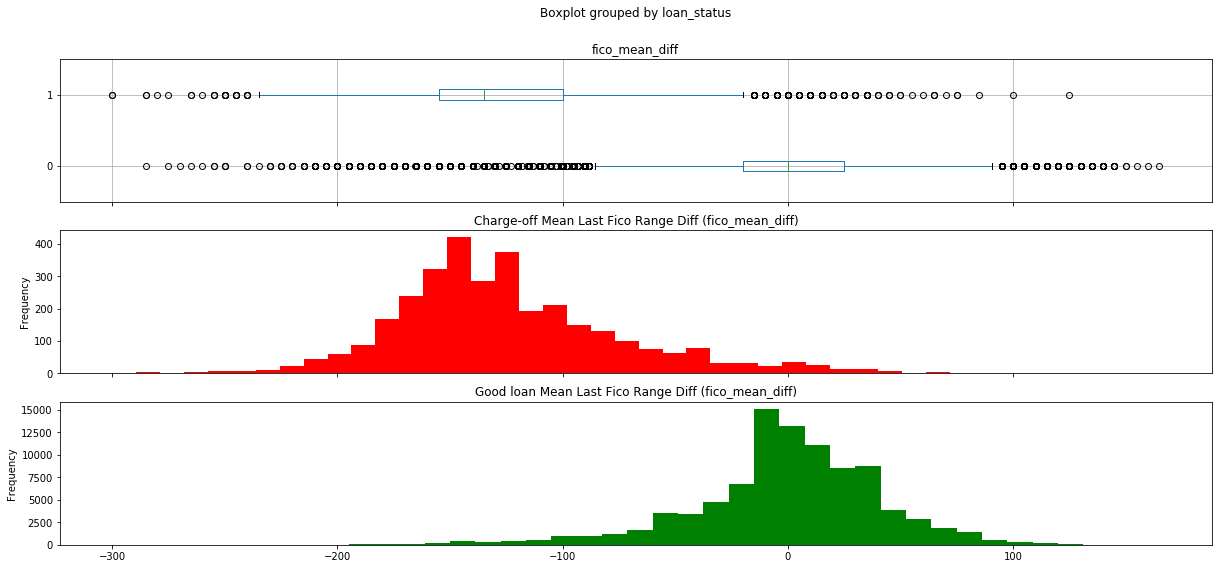

In [105]:
col = 'fico_mean_diff'
df[col] = df['last_fico_range_mean'] - df['fico_range_mean']
plot_box_hist2(df, col, title='Mean Last Fico Range Diff', bins=40)


### inq_last_6mths 
This feature strongly correlates with the charge-off status. It indicates the number of times credit inquiries were run on the borrower's credit history.
[Feature Index](#Features) 

Correlation of inq_last_6mths and charge-off: 0.959


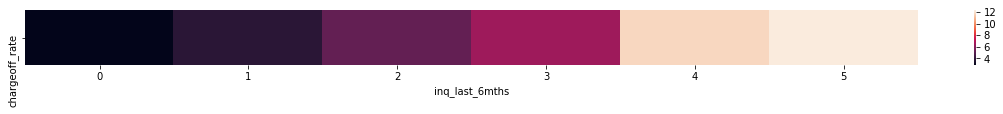

In [106]:
i6 = chargeoff_rank(df, 'inq_last_6mths')
i6r = i6.reset_index()
print("Correlation of inq_last_6mths and charge-off:", round(np.corrcoef(i6r.inq_last_6mths, i6r.chargeoff_rate)[0,1], 3))
plt.figure(figsize=(20,1)); sns.heatmap(i6.T);

Missing values: 0  Missing percent: 0.0


,inq_last_6mths
5,201
4,644
3,1908
2,7553
1,24462
0,61988


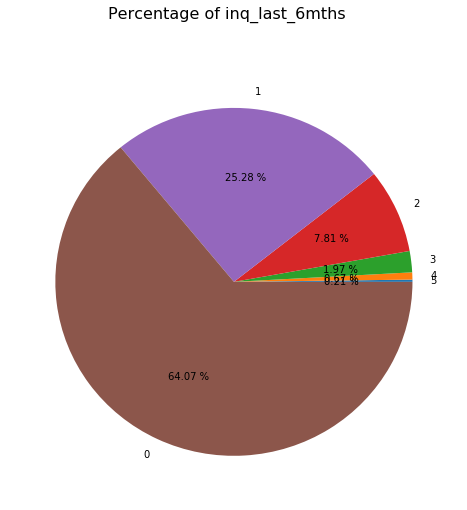

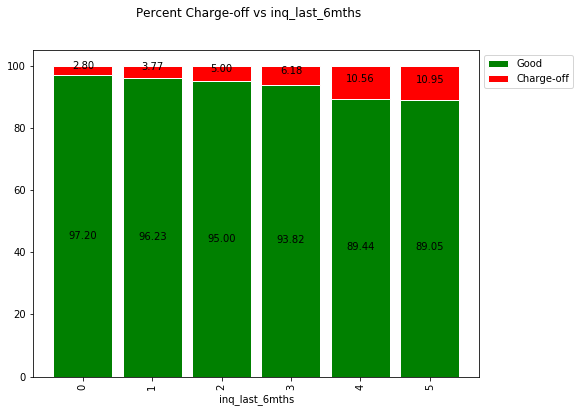

In [107]:
analyze_col(df, 'inq_last_6mths', showgroups=False, piesize=(8, 8))
percent_col(df, 'inq_last_6mths')

### mths_since_last_delinq
This feature does not seem to bear much on chargeoff rate: the correlation is low and slightly negative. I will convert it to years since last delinquent and drop the mths_since_last_delinq column.
[Feature Index](#Features) 

Number of Nulls: 46286


count    50470.000000
mean        33.553259
std         21.876251
min          0.000000
25%         15.000000
50%         30.000000
75%         49.000000
max        137.000000
Name: mths_since_last_delinq, dtype: float64

Correlation of mths_since_last_delinq and charge-off: -0.212


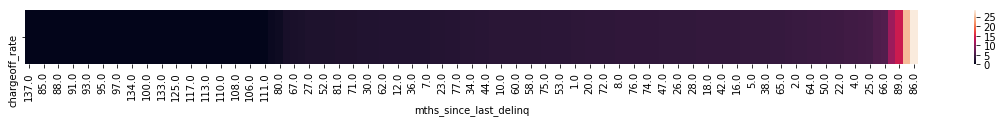

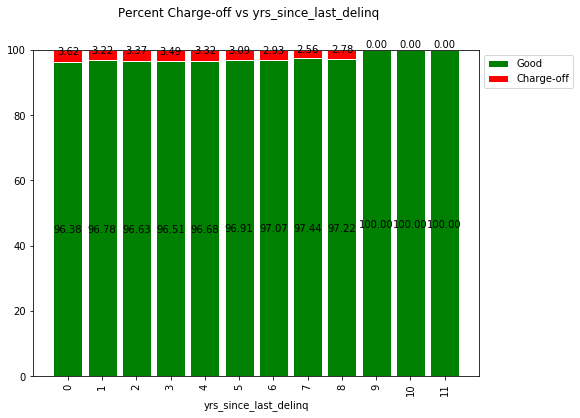

In [108]:
col = 'mths_since_last_delinq'
df[col] = X[col]
print("Number of Nulls:", sum(df[col].isnull()))
display(df[col].describe())

# impute. Since the larger the number of months since delinquent is the better, 
# I will impute missing values assuming that they have not been delinquent and assign the max value.
df[col].fillna(np.mean(df[col]), inplace=True)

corr_heatmap(df, col)
df['yrs_since_last_delinq'] = df[col] // 12
percent_col(df, 'yrs_since_last_delinq')

### mths_since_last_record
What is worth noting here is that 0 years since last record have twice the charge-off rate as 1 year since last record. This feature may not be valuable if considering even though it has low correlation with charge-off.
[Feature Index](#Features) 

Number of Nulls: 77653


count    19103.000000
mean        68.749359
std         25.557495
min          0.000000
25%         53.000000
50%         72.000000
75%         87.000000
max        120.000000
Name: mths_since_last_record, dtype: float64

Correlation of mths_since_last_record and charge-off: 0.098


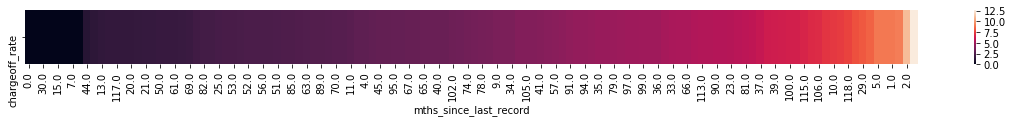

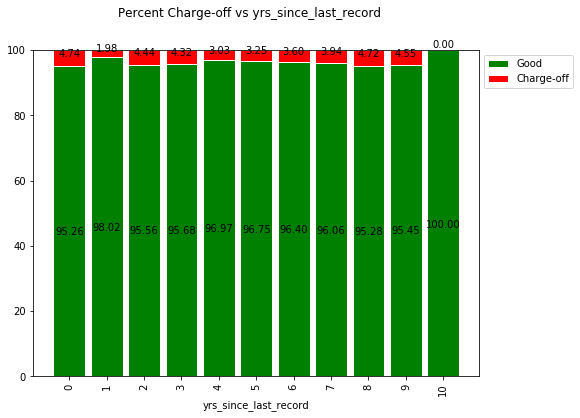

In [109]:
col = 'mths_since_last_record'
df[col] = X[col]
print("Number of Nulls:", sum(df[col].isnull()))
display(df[col].describe())

# impute. Since the larger the number of months since delinquent is the better, 
# I will impute missing values assuming that they have not been delinquent and assign the max value.
df[col].fillna(np.mean(df[col]), inplace=True)

corr_heatmap(df, col)
df['yrs_since_last_record'] = df[col] // 12
percent_col(df, 'yrs_since_last_record')

### open_acc
The number of open credit lines in the borrower's credit file. 
[Feature Index](#Features) 

Number of Nulls: 0


count    96756.000000
mean        11.800188
std          5.741949
min          1.000000
25%          8.000000
50%         11.000000
75%         15.000000
max         72.000000
Name: open_acc, dtype: float64

Correlation of open_acc and charge-off: -0.428


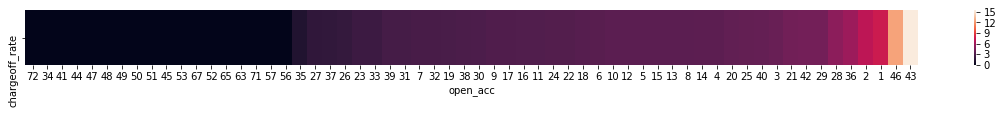

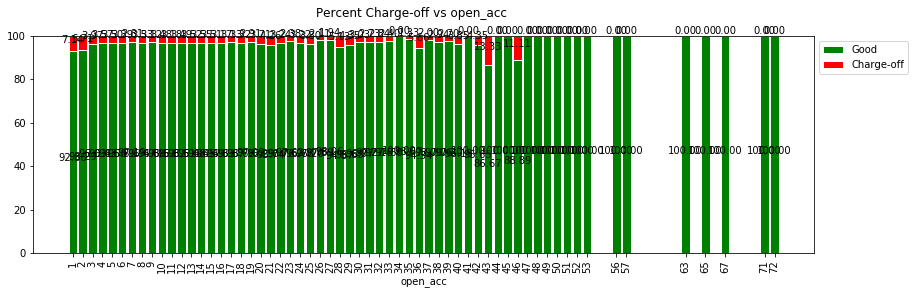

In [110]:
col = 'open_acc'
print("Number of Nulls:", sum(df[col].isnull()))
display(df[col].describe())
corr_heatmap(df, col)
percent_col(df, col, figsize=(14,4))

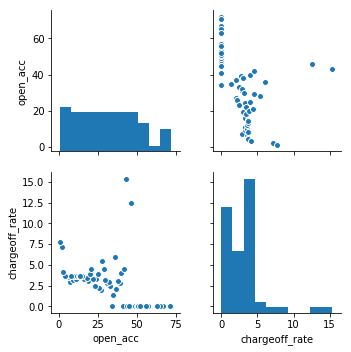

In [111]:
cr = chargeoff_rank(df, 'open_acc').reset_index()
sns.pairplot(cr);

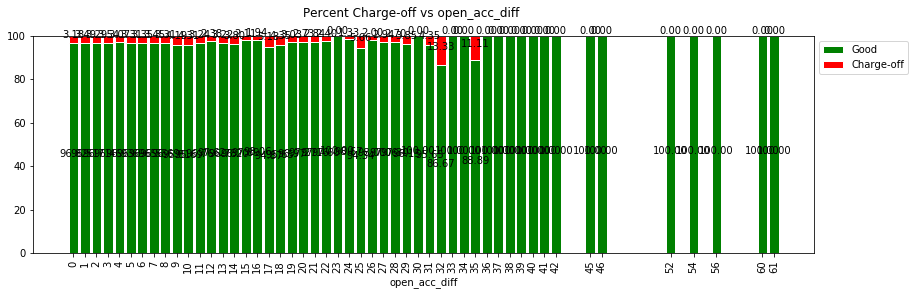

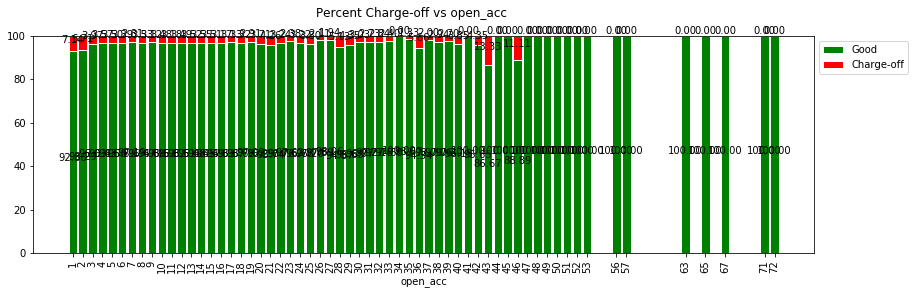

In [112]:
df['open_acc_diff'] = np.abs(df['open_acc'] - 11)
percent_col(df, 'open_acc_diff', figsize=(14,4))
percent_col(df, 'open_acc', figsize=(14,4))


### pub_rec
Number of derogatory public records.  The correlation is close to 0, 
[Feature Index](#Features) 

Number of Nulls: 0


count    96756.000000
mean         0.266350
std          0.716511
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max         61.000000
Name: pub_rec, dtype: float64

Correlation of pub_rec and charge-off: -0.05
Missing values for pub_rec 0


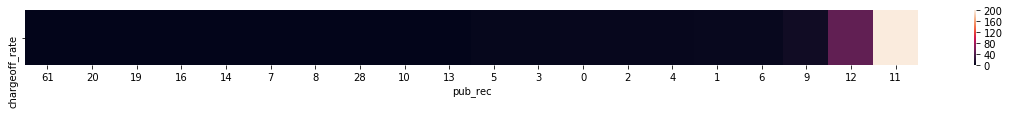

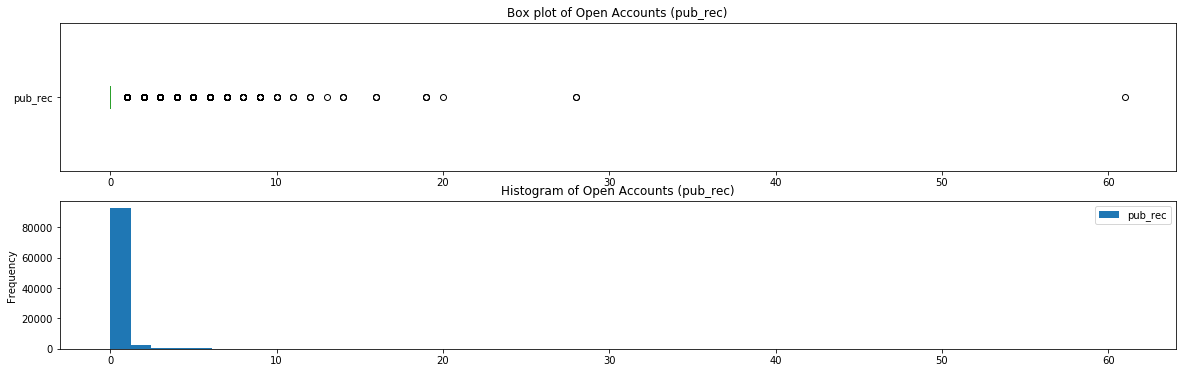

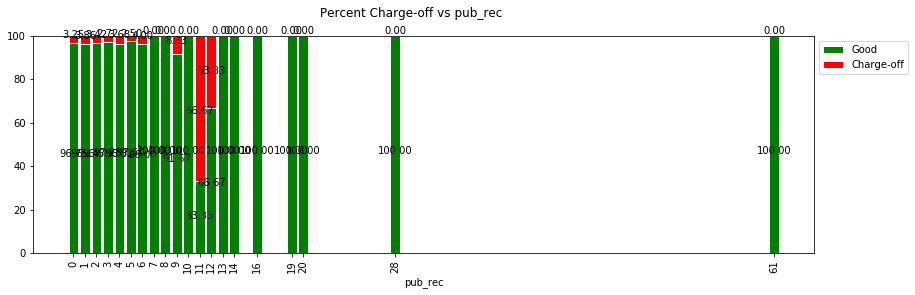

In [113]:
col = 'pub_rec'
print("Number of Nulls:", sum(df[col].isnull()))
display(df[col].describe())
corr_heatmap(df, col)
plot_box_hist(df, col, title='Open Accounts', bins=50)
percent_col(df, col, figsize=(14,4))

### revol_bal
Needs to be log encoded.
[Feature Index](#Features) 

Number of Nulls: 0


count    9.675600e+04
mean     1.716275e+04
std      2.328499e+04
min      0.000000e+00
25%      6.388000e+03
50%      1.169800e+04
75%      2.062525e+04
max      1.698749e+06
Name: revol_bal, dtype: float64

Missing values for revol_bal 0


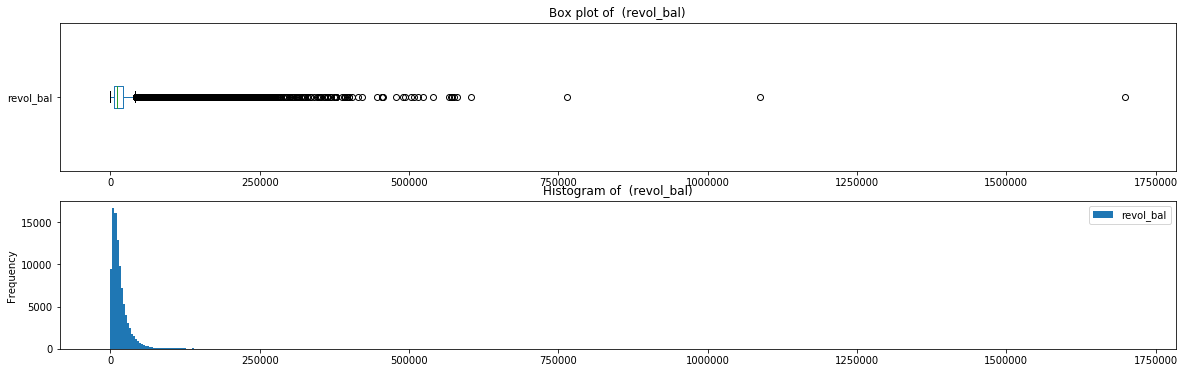

Missing values for revol_bal 0


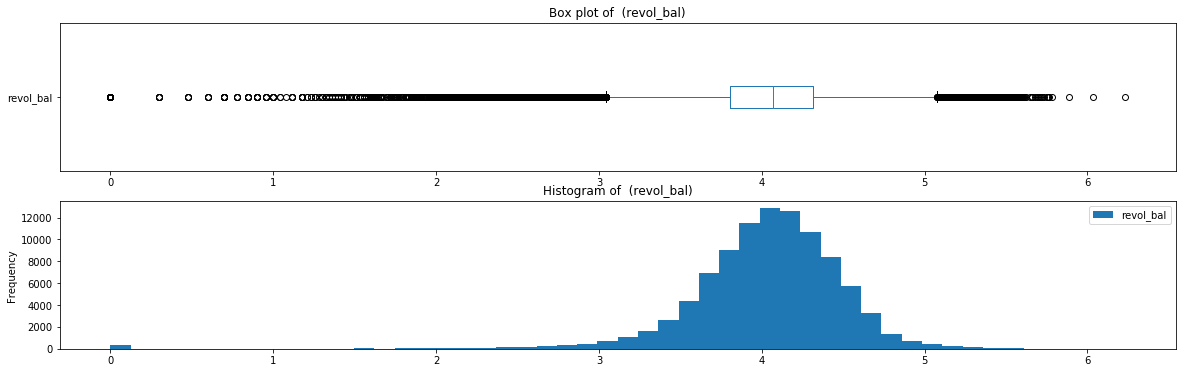

In [114]:
col = 'revol_bal'
print("Number of Nulls:", sum(df[col].isnull()))
display(df[col].describe())
plot_box_hist(df, col, bins=500)
df[col] = df[col].apply(log10_c)
plot_box_hist(df, col, bins=50)



### revol_util
Revolving line utilization rate, or the amount of credit the borrower is using relative to all available revolving credit. 
Binning revol_util to 10% increment reveals a linear trend of increasing charge-off. 
We can still see that revol_util < 10 and revol_util > 75 have higher charge-off rates
Then above 100% revol_util the chargeoff rate is 0!


[Feature Index](#Features) 

Missing values for revol_util 51


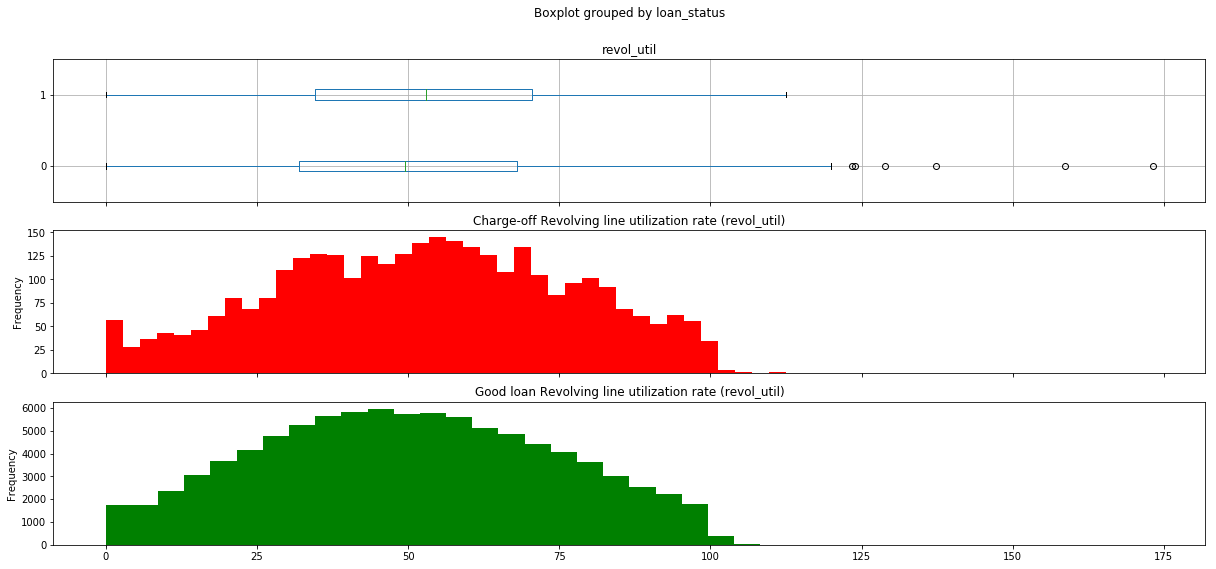

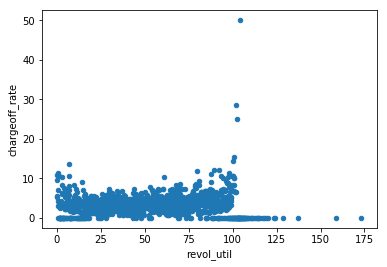

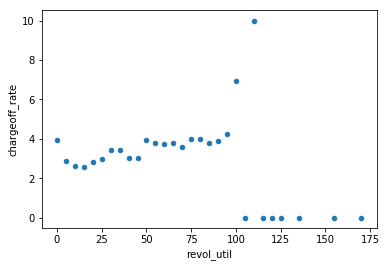

In [115]:
#df[col] = X[col]
col = 'revol_util'
df[col] = X[col]

df[col] = df[col].apply(pct_c)

plot_box_hist2(df, col, title='Revolving line utilization rate', bins=40)

pm = df[col].mean()
df[col].fillna(pm, inplace=True)

df[col] = round(df[col], 1) #.astype(int)
cr = chargeoff_rank(df, col).reset_index()
cr.plot.scatter(x=col, y='chargeoff_rate');

df[col] = ((df[col] // 5) * 5)
cr = chargeoff_rank(df, col).reset_index()
cr.plot.scatter(x=col, y='chargeoff_rate');

### total_acc
[Feature Index](#Features) 

Missing values: 0
Missing values: 0  Missing percent: 0.0


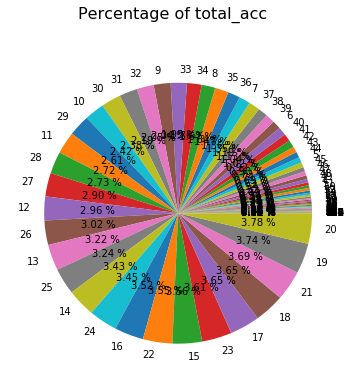

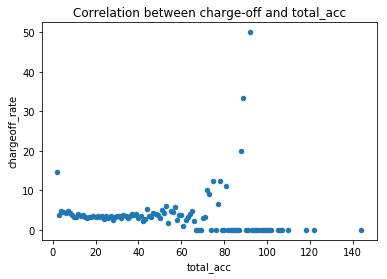

In [116]:
col = 'total_acc'
print("Missing values:", df[col].isnull().sum())
analyze_col(df, col, showtable=False)
cr = chargeoff_rank(df, col).reset_index()
cr.plot.scatter(x=col, y='chargeoff_rate', title='Correlation between charge-off and ' + col);

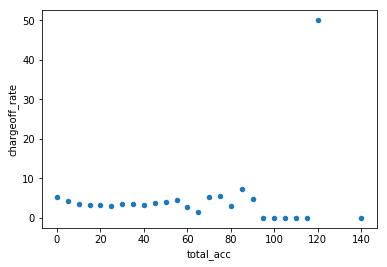

In [117]:
df[col] = ((df[col] // 5) * 5)
cr = chargeoff_rank(df, col).reset_index()
cr.plot.scatter(x=col, y='chargeoff_rate');

### initial_list_status
[Feature Index](#Features) 

Missing values: 0  Missing percent: 0.0


,initial_list_status
f,27903
w,68853


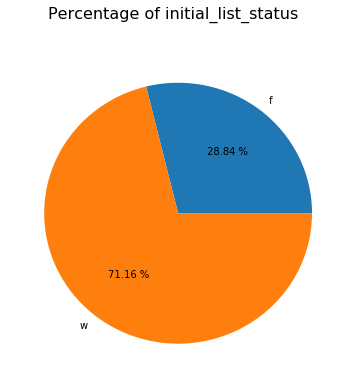

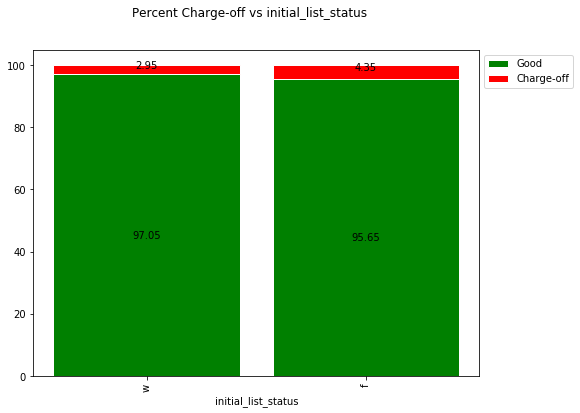

In [118]:
col = 'initial_list_status'
df[col] = X[col]
analyze_col(df, col)
percent_col(df, col)

In [119]:
df[col].unique()
initial_list_status_c = lambda x: 0 if x == 'w' else 1
df[col] = df[col].apply(initial_list_status_c)

### collections_12_mths_ex_med
Since there are so few instances with collections_12_mths_ex_med > 1, I will encode this as collection = 1, no collection = 0.

[Feature Index](#Features) 

Missing values: 0  Missing percent: 0.0


,collections_12_mths_ex_med
12,1
5,3
4,3
3,9
2,112
1,1837
0,94791


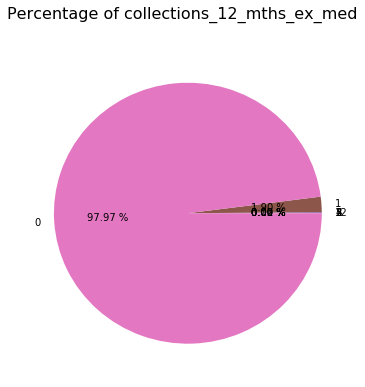

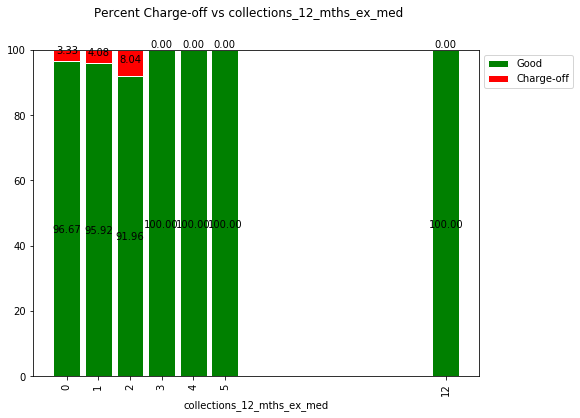

In [120]:
col = 'collections_12_mths_ex_med'
df[col] = X[col]
analyze_col(df, col)
percent_col(df, col)

Missing values: 0  Missing percent: 0.0


,collections_12_mths_ex_med
1,1965
0,94791


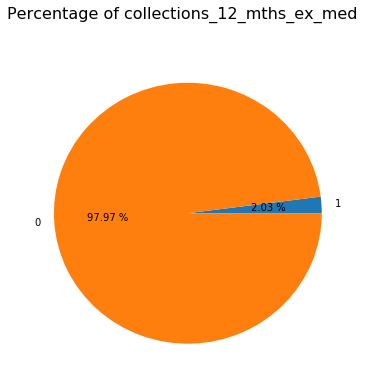

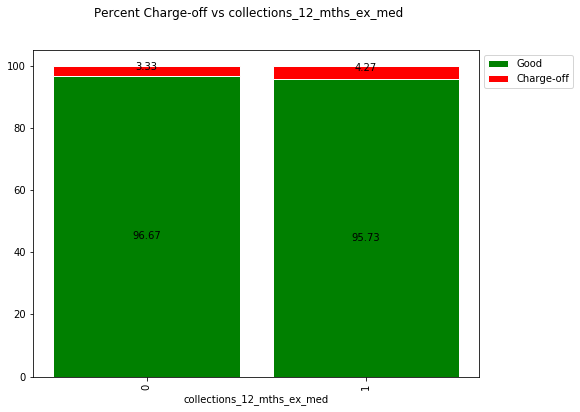

In [121]:
collections_12_mths_ex_med_c = lambda x: 0 if x == 0 else 1
df['collections_12_mths_ex_med'] = df['collections_12_mths_ex_med'].apply(collections_12_mths_ex_med_c)
analyze_col(df, col)
percent_col(df, col)

### mths_since_last_major_derog
Since 3 quarters values are missing, I will drop the column.
[Feature Index](#Features) 

Perecent missing: 72.00690396461201
Missing values: 69671  Missing percent: 0.7200690396461201


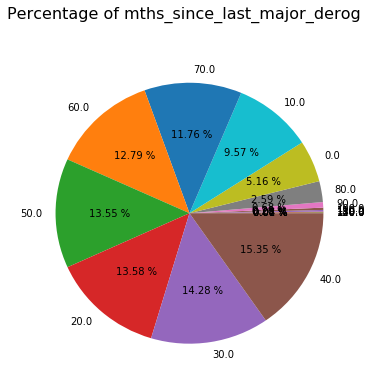

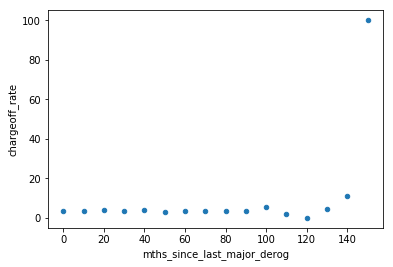

In [122]:
col = 'mths_since_last_major_derog'
df[col] = X[col]
print("Perecent missing:", 100* df[col].isnull().sum() / len(df))
df[col] = df[col] // 10 * 10
analyze_col(df, col, showtable=False)
cr = chargeoff_rank(df, col).reset_index()
cr.plot.scatter(x=col, y='chargeoff_rate');

### tot_hi_cred_lim
[Feature Index](#Features) 

Missing values for tot_hi_cred_lim 0


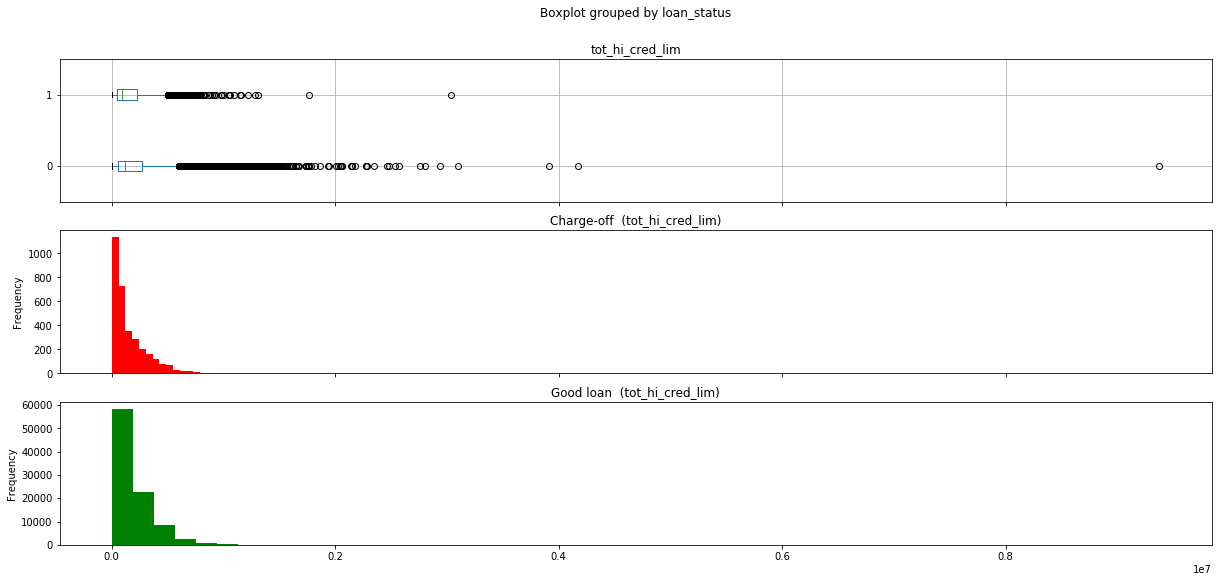

In [123]:
col = 'tot_hi_cred_lim'
plot_box_hist2(df, col, bins=50)


Missing values for tot_hi_cred_lim 0


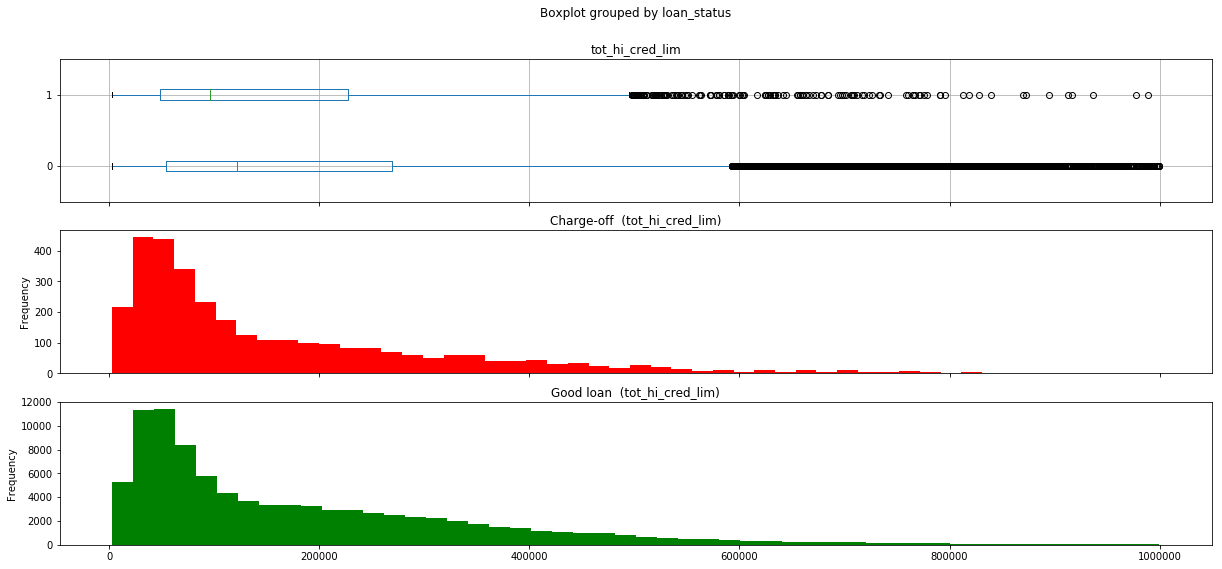

In [124]:
plot_box_hist2(df[df[col] < 1e6], col, bins=50)


### money columns
[Feature Index](#Features) 

Missing values for tot_hi_cred_lim 0


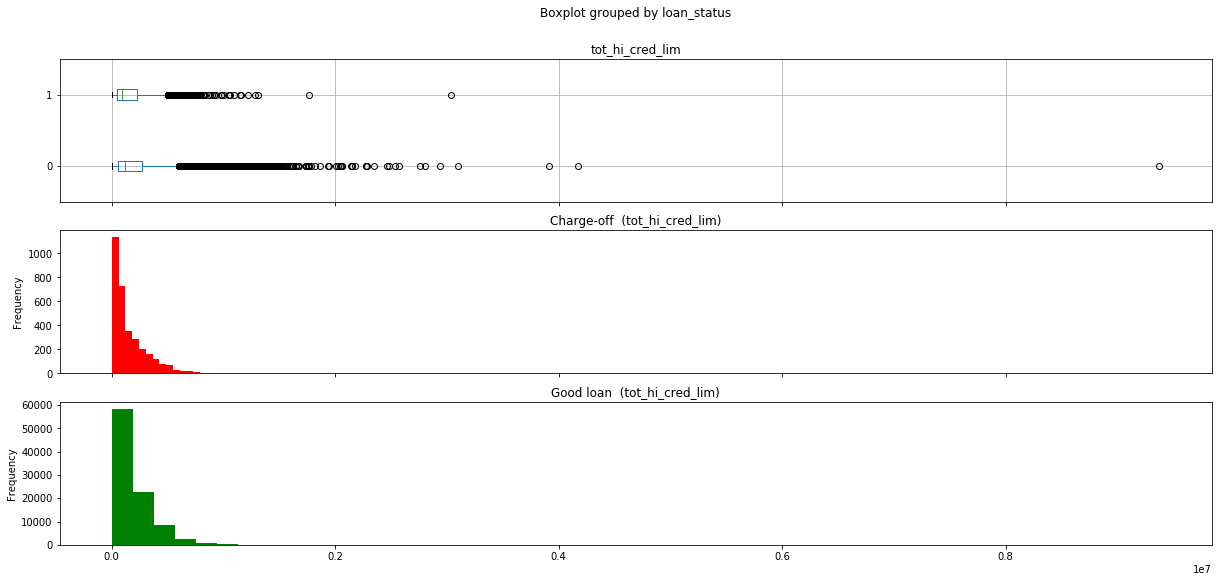

Missing values for tot_cur_bal 0


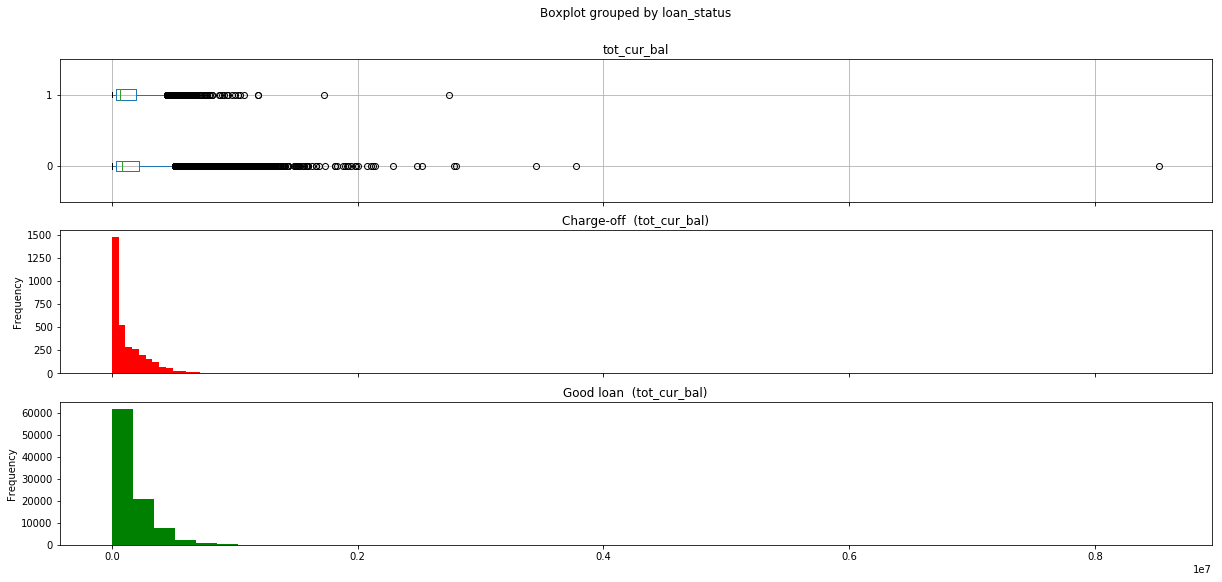

Missing values for total_bal_ex_mort 0


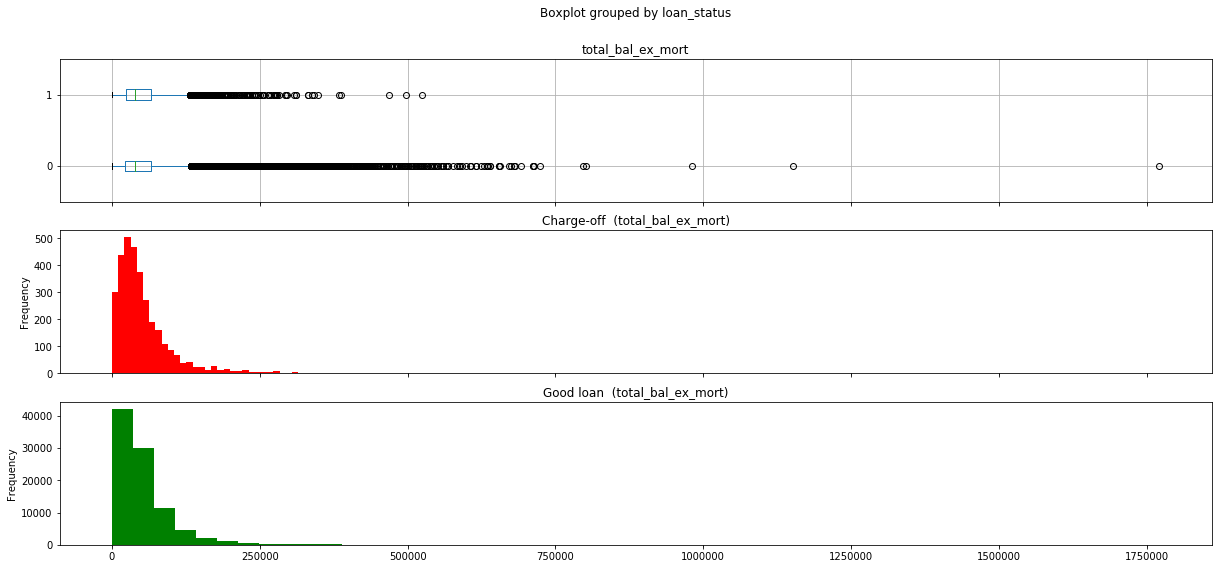

Missing values for total_il_high_credit_limit 0


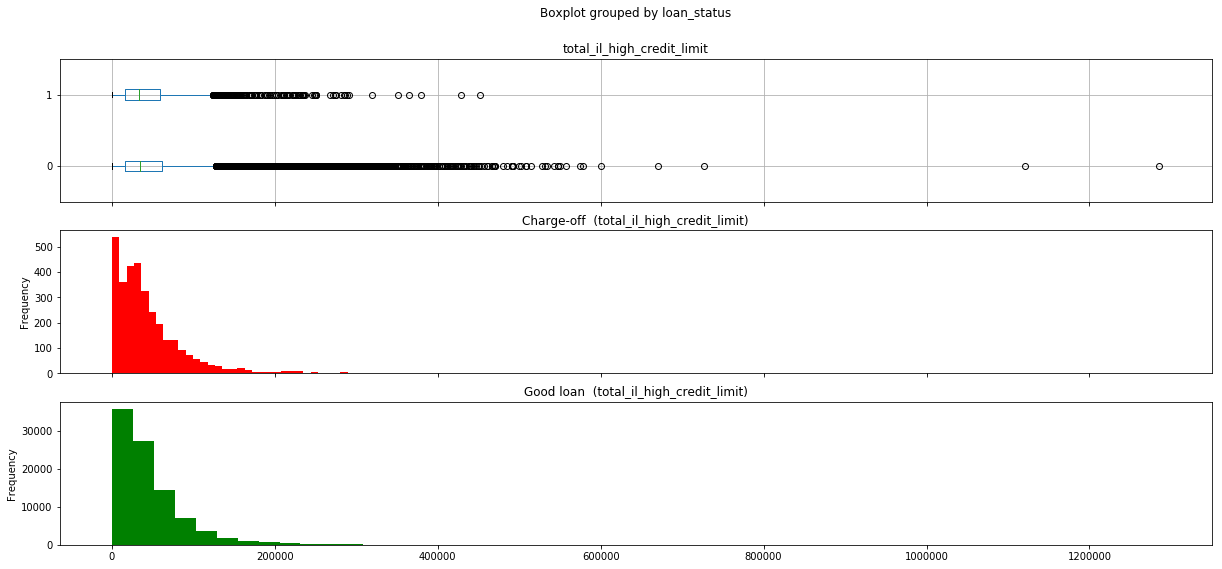

Missing values for total_rev_hi_lim 0


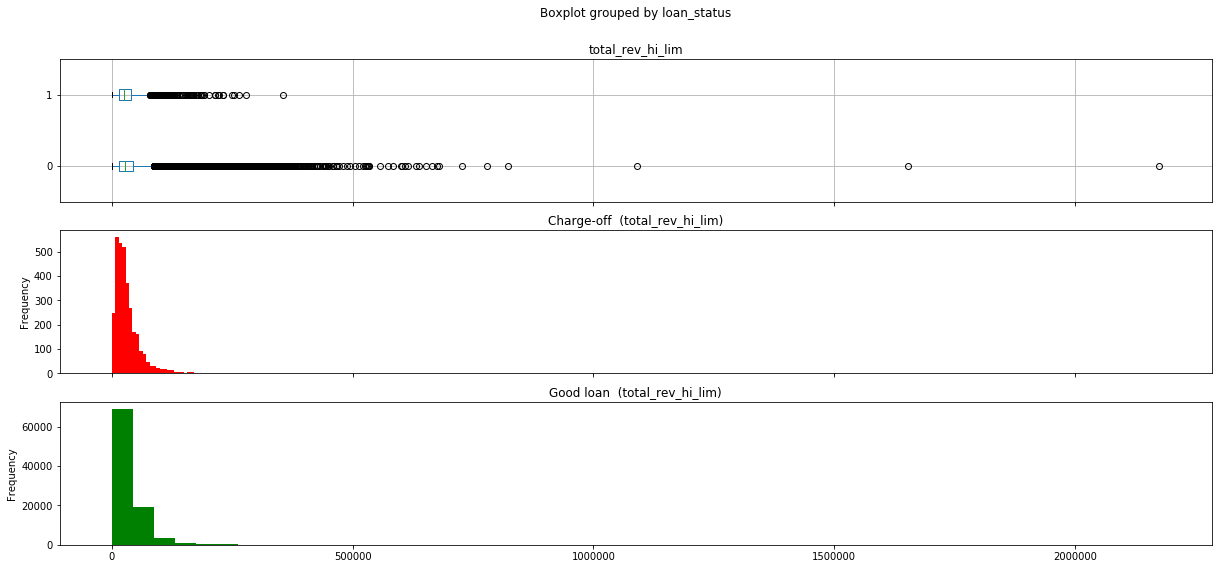

Missing values for total_bal_il 0


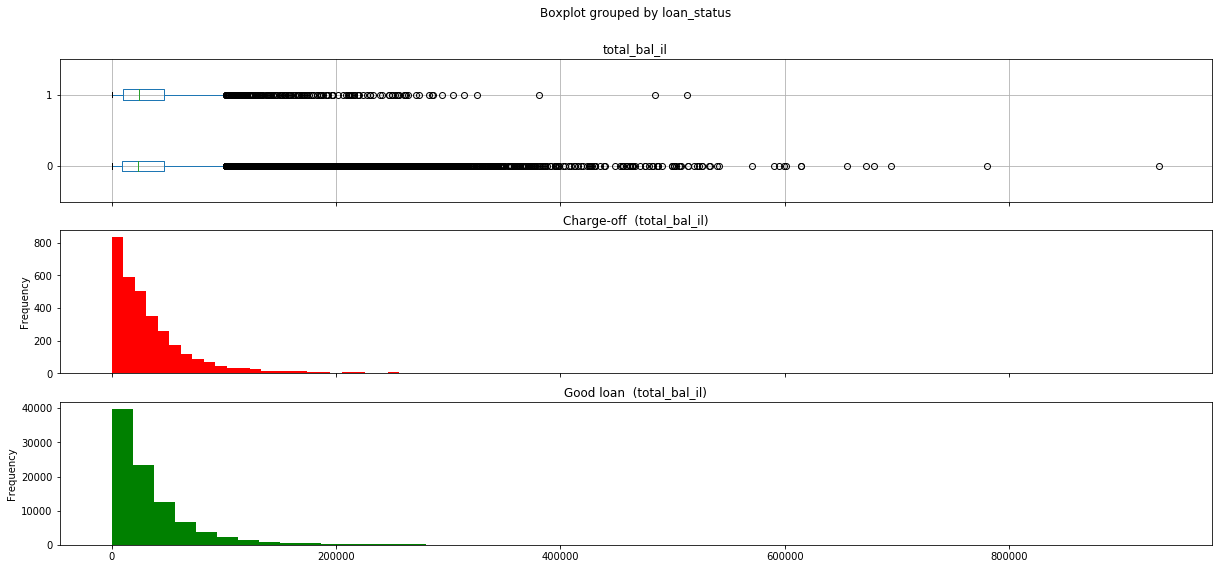

Missing values for total_bc_limit 0


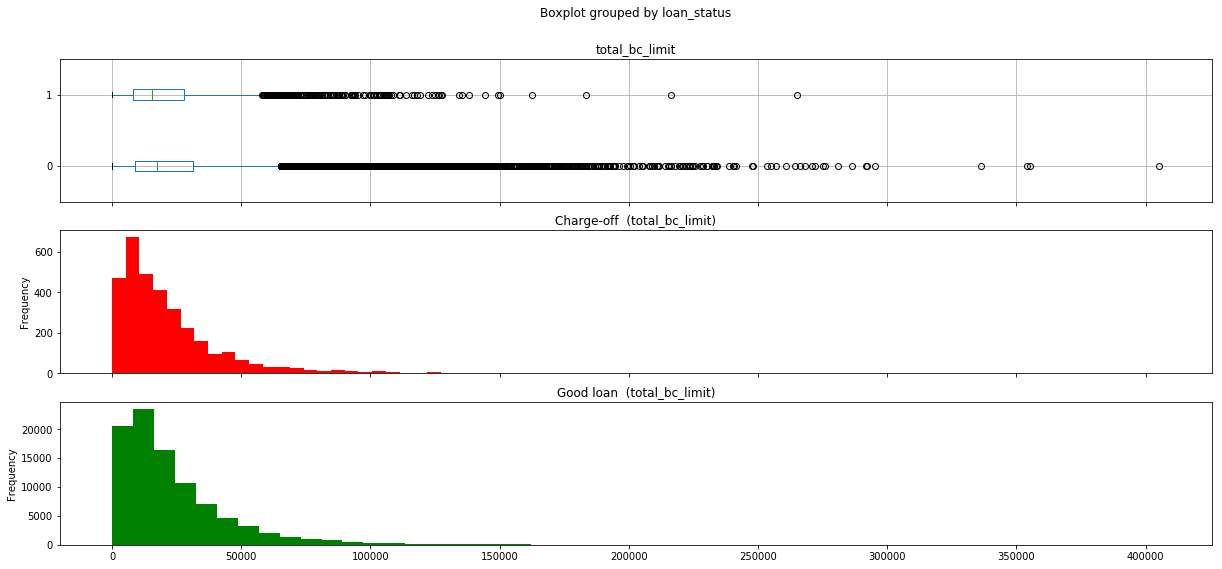

Missing values for loan_amnt 0


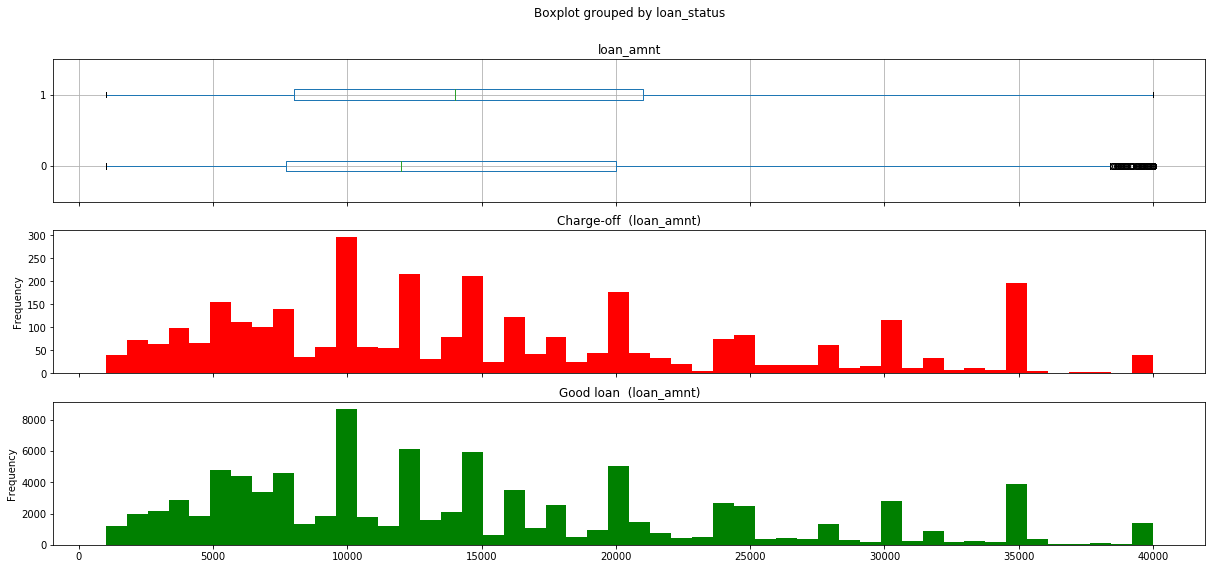

Missing values for avg_cur_bal 0


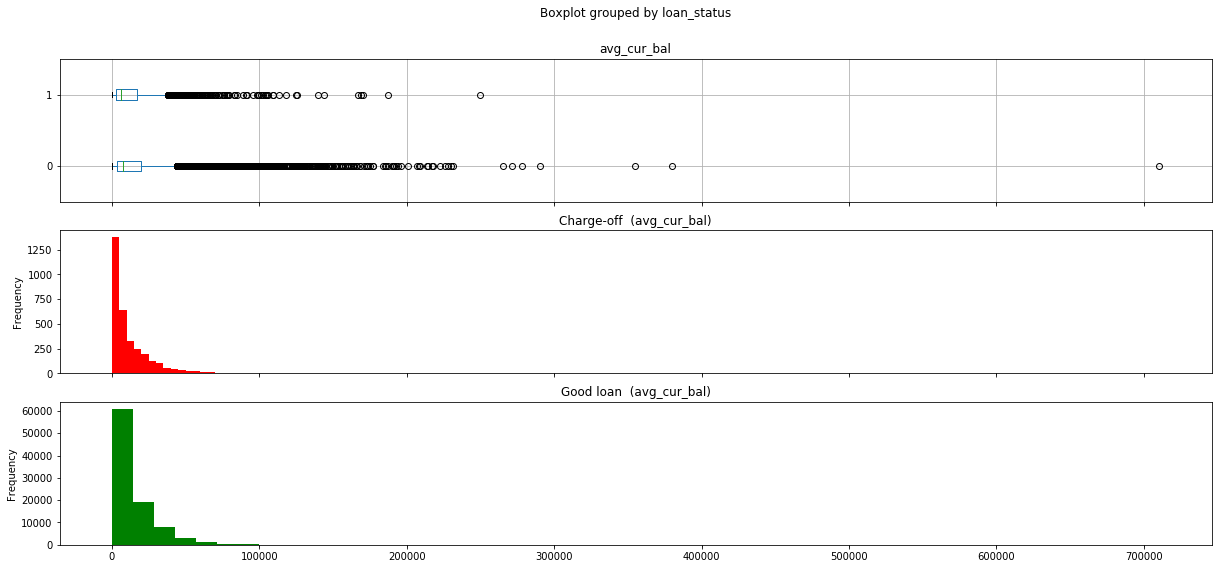

Missing values for bc_open_to_buy 985


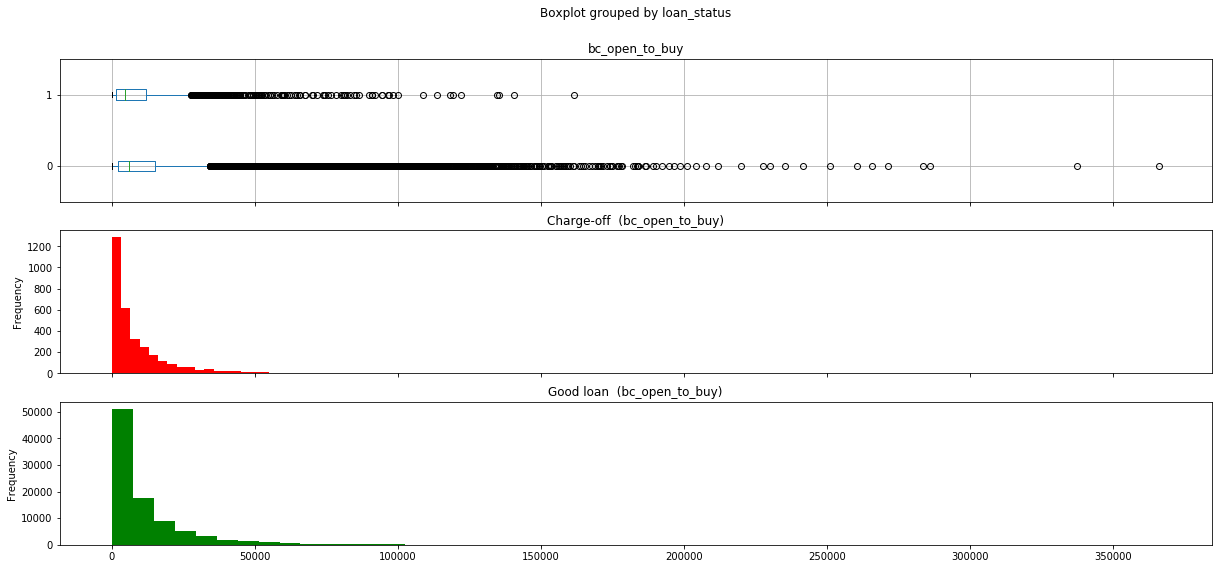

Missing values for max_bal_bc 0


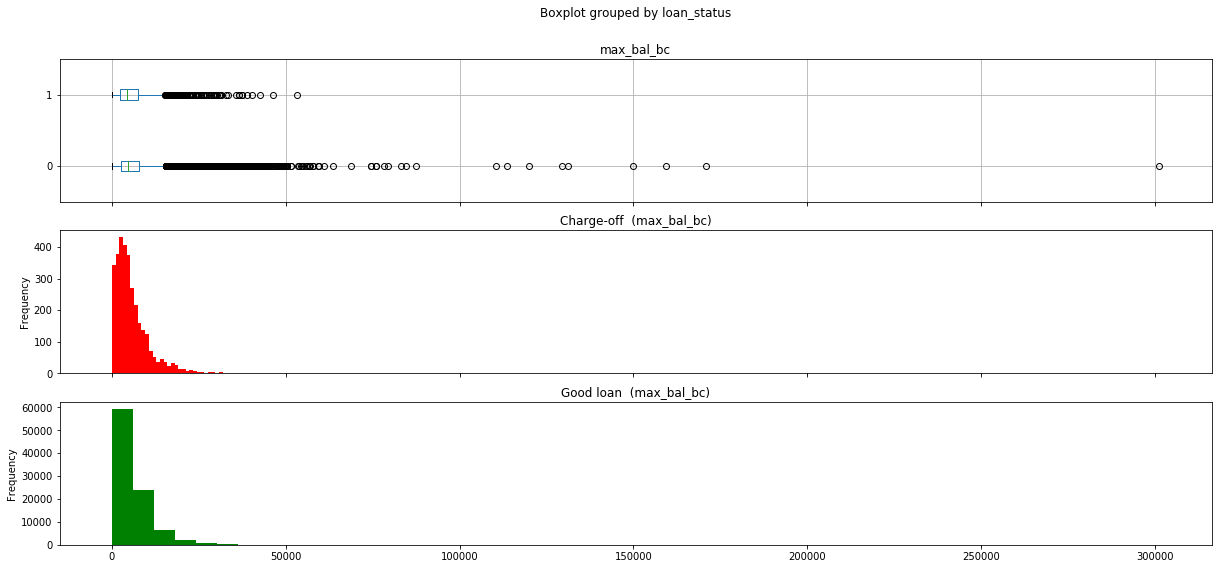

In [125]:
money_cols = ['tot_hi_cred_lim', 'tot_cur_bal', 'total_bal_ex_mort',
       'total_il_high_credit_limit', 'total_rev_hi_lim', 'total_bal_il',
       'total_bc_limit', 'loan_amnt', 'avg_cur_bal', 'bc_open_to_buy',
       'max_bal_bc']

for col in money_cols:
    plot_box_hist2(df, col, bins=50)


Missing values for tot_hi_cred_lim 0


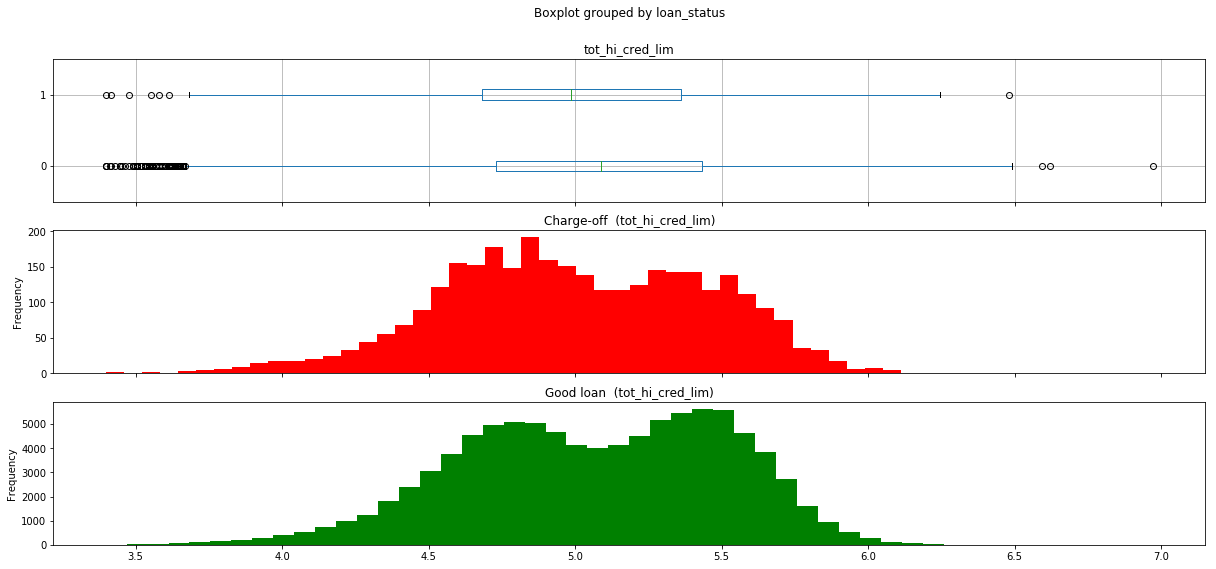

Missing values for tot_cur_bal 0


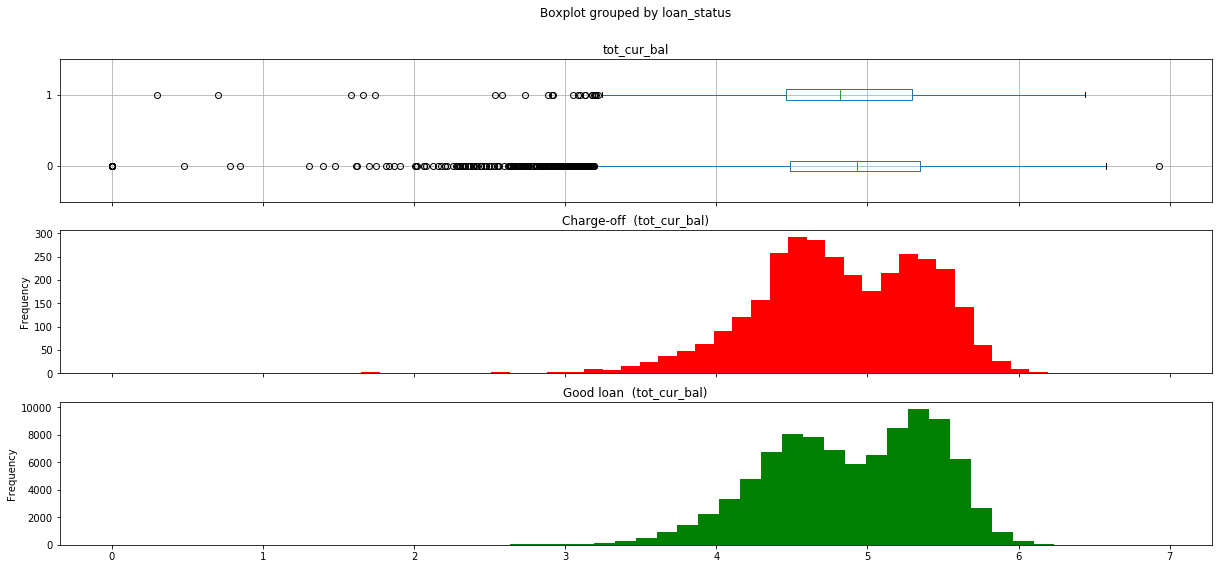

Missing values for total_bal_ex_mort 0


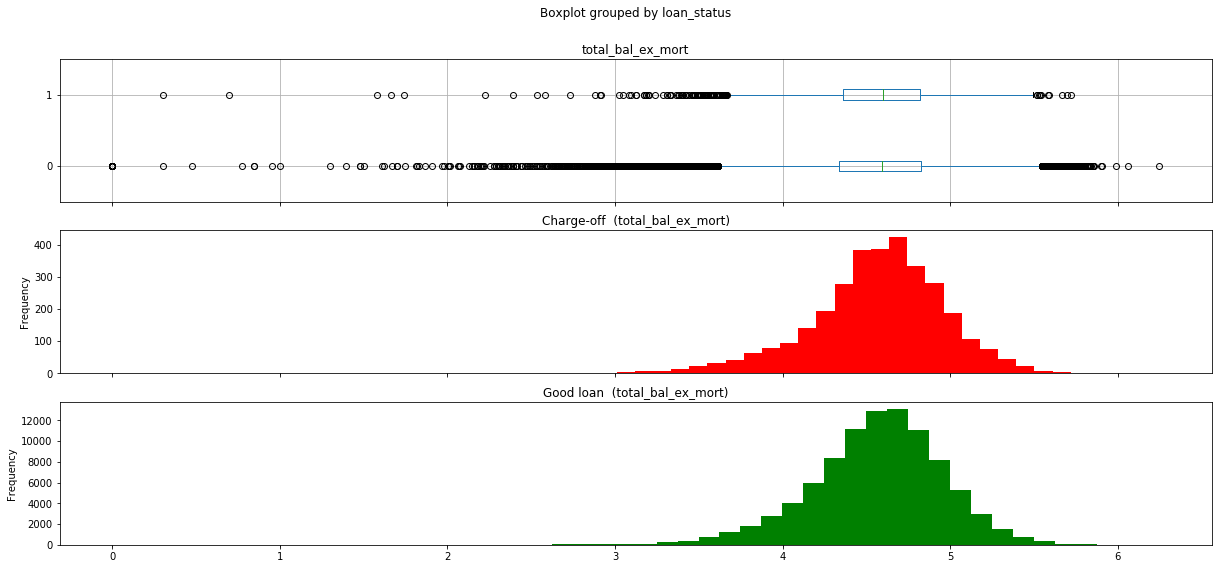

Missing values for total_il_high_credit_limit 0


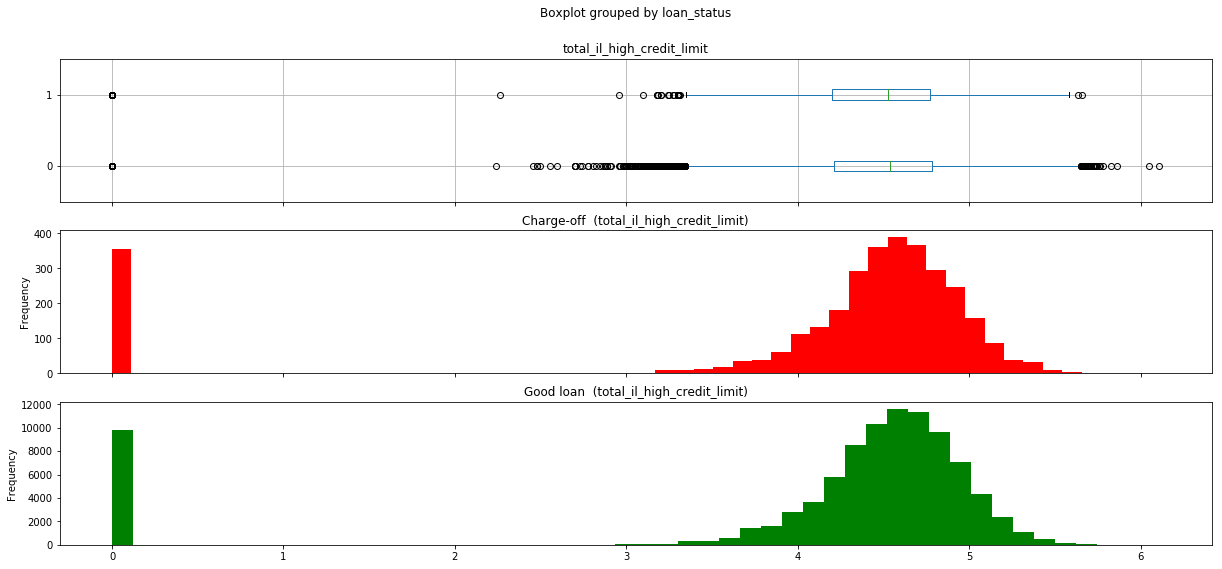

Missing values for total_rev_hi_lim 0


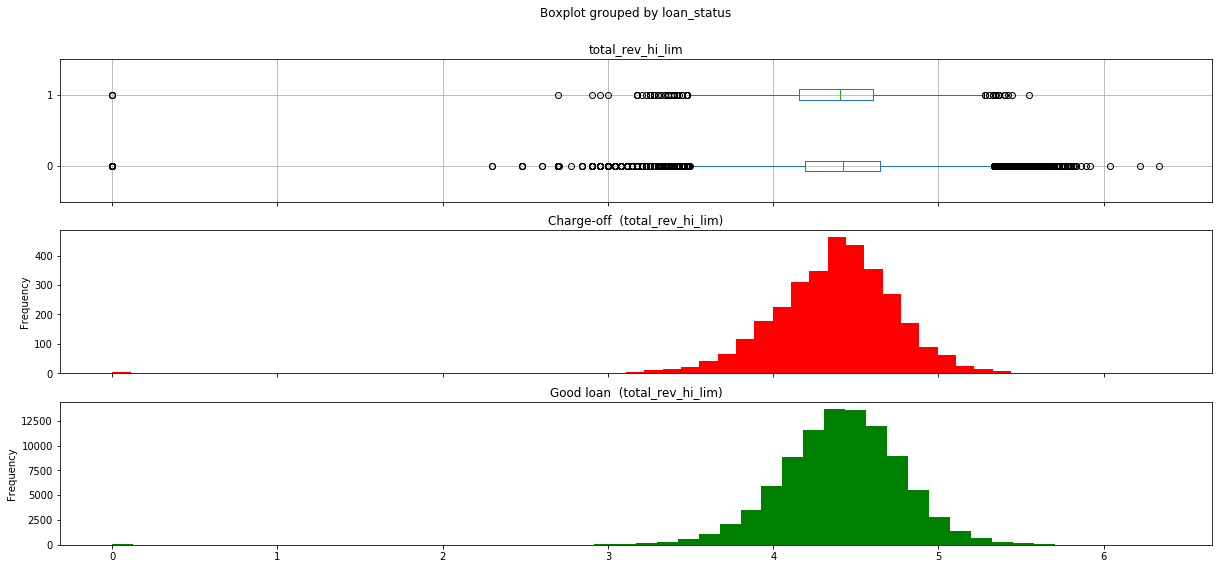

Missing values for total_bal_il 0


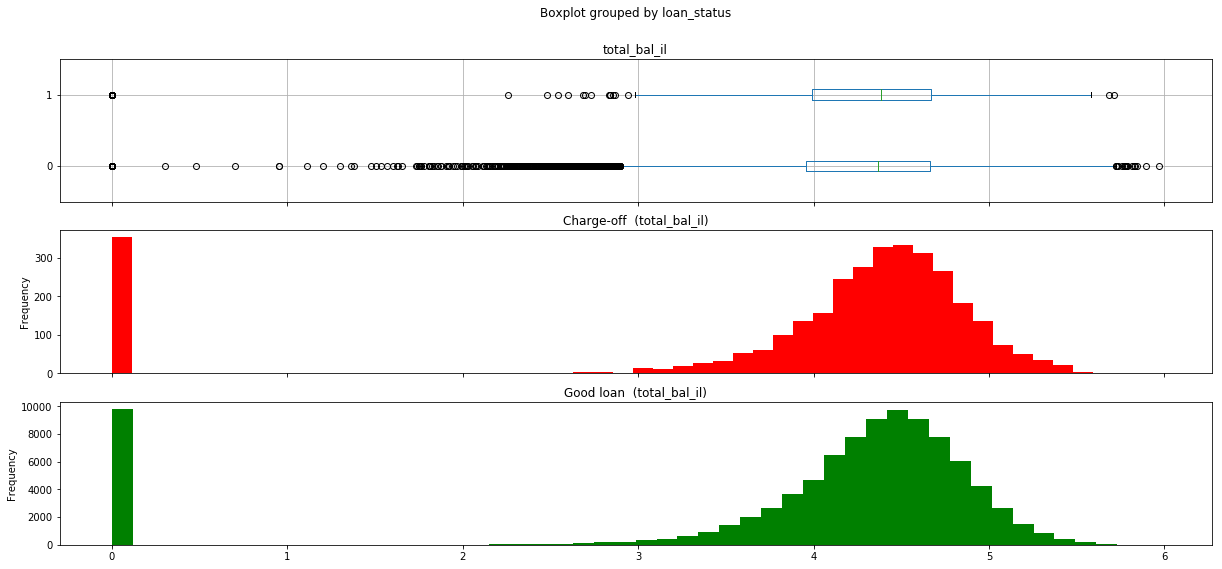

Missing values for total_bc_limit 0


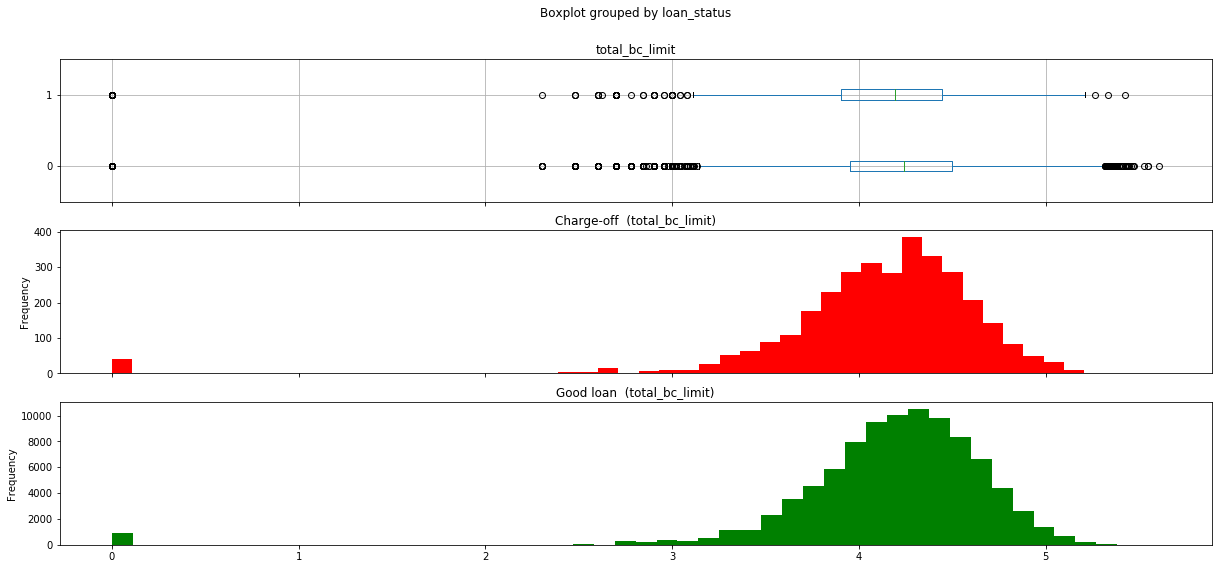

Missing values for loan_amnt 0


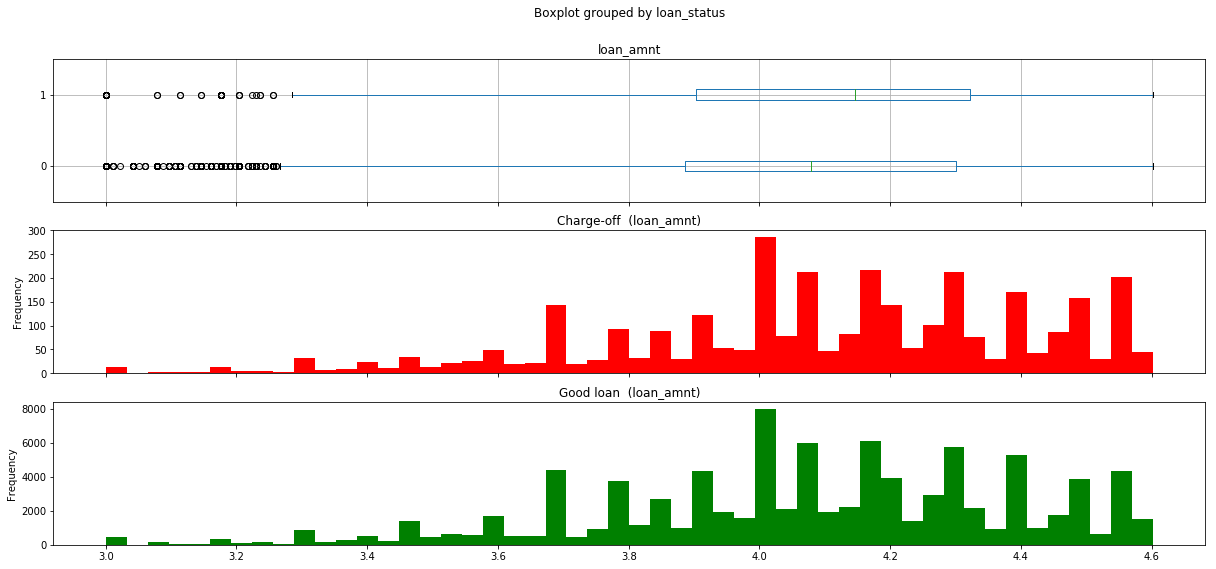

Missing values for avg_cur_bal 0


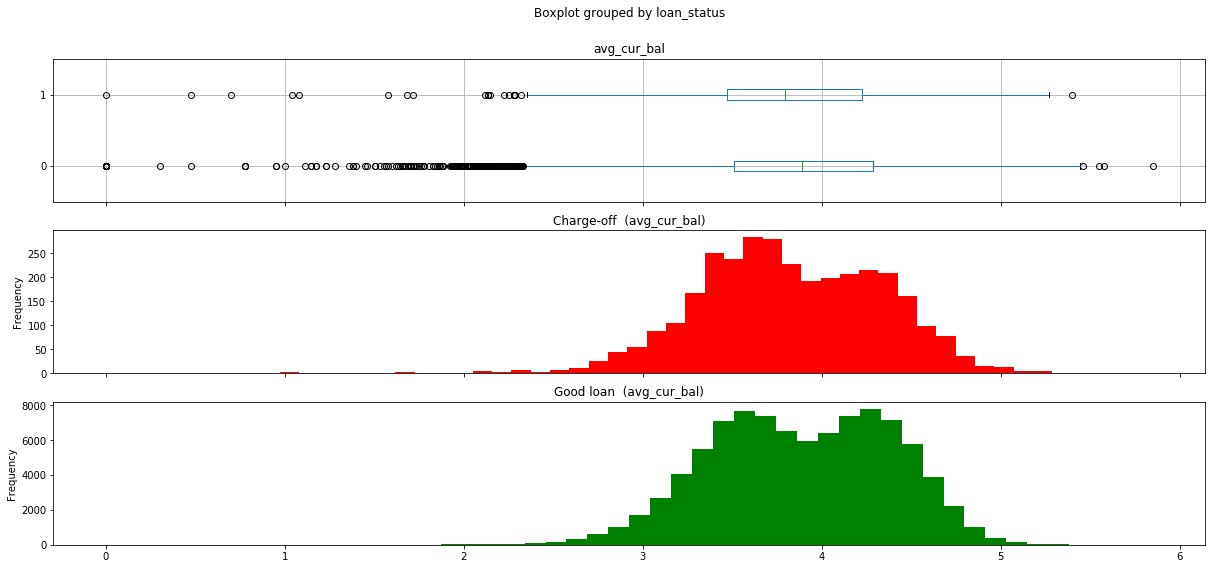

Missing values for bc_open_to_buy 985


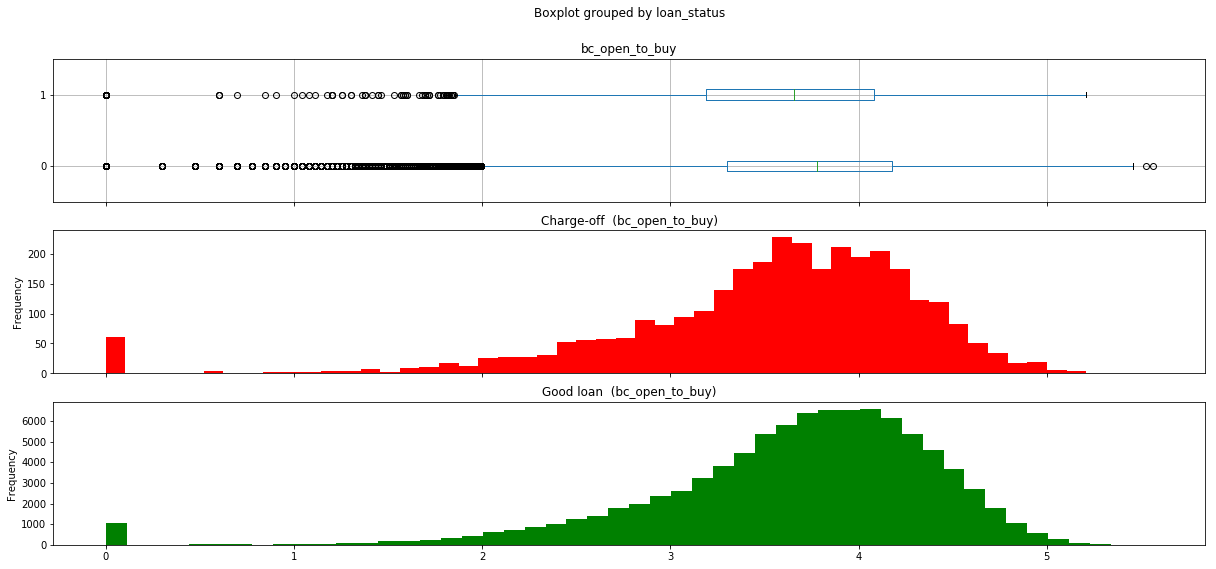

Missing values for max_bal_bc 0


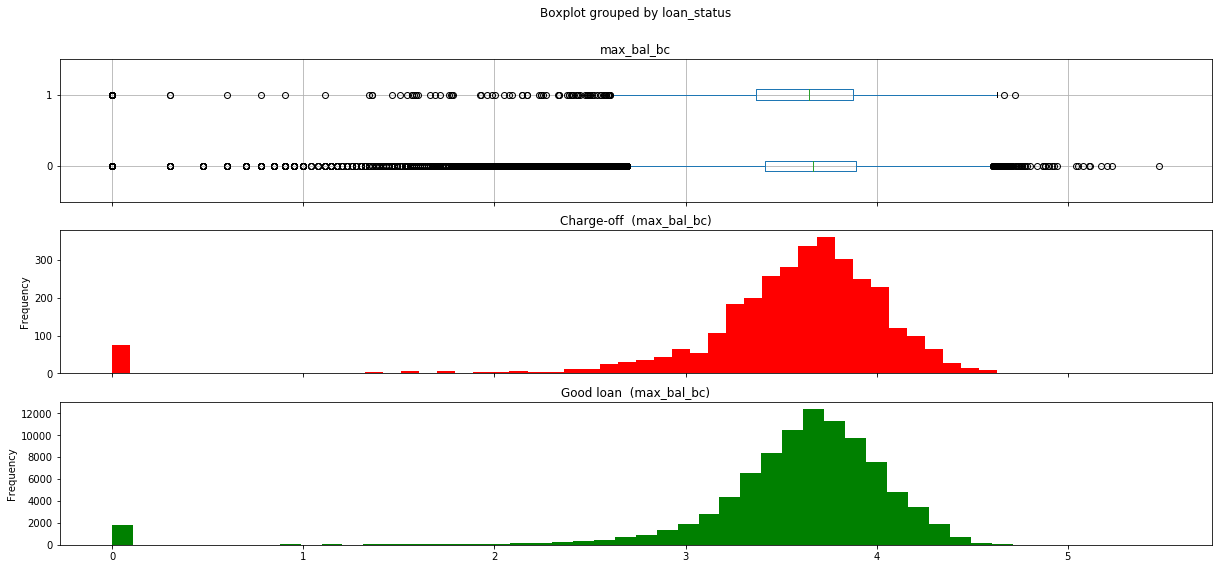

In [126]:
for col in money_cols:
    df[col] = df[col].apply(log10_c)
    plot_box_hist2(df, col, bins=50)